<a href="https://colab.research.google.com/github/hongchen-wang/ML-QuantitativeTrading/blob/main/QuantitativeTrading_unsupervised_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pandas-ta
import pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=1c91bd82a88b0f6f09329791f0794451507f4548d793f0a1db54e1c963c26847
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [ ]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
497,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [ ]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()


In [ ]:
end_date = '2024-06-17'
start_date= pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list, start=start_date, end=end_date)

[*********************100%%**********************]  502 of 502 completed


In [ ]:
df = df.stack()

In [ ]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

In [ ]:
# Garman-Klass Volatility
df['garman_klass_vol'] = (np.log(df['high']) - np.log(df['low'])**2)/2-(2*np.log(2)-1) * (np.log(df['adj close']) - np.log(df['open']))**2
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-20 A        43.216743   46.139999   46.349998   45.570000   45.570000   
           AAL      28.552008   29.709999   30.389999   29.639999   29.750000   
           AAPL     21.837021   23.775000   24.142500   23.757500   24.000000   
           ABBV     42.599014   60.110001   61.180000   60.060001   60.639999   
           ABT      32.582180   37.750000   38.070000   37.750000   37.880001   
...                       ...         ...         ...         ...         ...   
2024-06-14 XYL     138.020004  138.020004  140.369995  135.990005  139.419998   
           YUM     136.789993  136.789993  137.880005  136.029999  137.380005   
           ZBH     106.952286  107.190002  107.300003  106.010002  106.680000   
           ZBRA    301.369995  301.369995  305.489990  298.679993  305.489990   
           ZTS     170.550003  170.550003  171.589996  168.889999  170.449997   

Price                   volume  garman_klass_vol  
date       ticker                                 
2016-06-20 A         3161300.0         -5.376309  
           AAL       8359300.0         -4.036679  
           AAPL    137647600.0         -3.429249  
           ABBV      7076500.0         -6.377181  
           ABT       7707300.0         -4.781083  
...                        ...               ...  
2024-06-14 XYL        883100.0         -9.594626  
           YUM       1418500.0         -9.604988  
           ZBH       1611400.0         -8.536460  
           ZBRA       218800.0        -13.380538  
           ZTS       2225300.0        -10.582037  

[989576 rows x 7 columns]

<Axes: xlabel='date'>

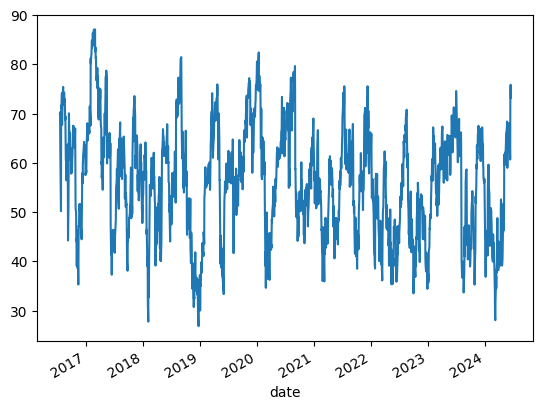

In [ ]:
 # RSI
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df.xs('AAPL', level=1)['rsi'].plot()

In [ ]:
# Bollinger Bands
# pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)
df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])

In [ ]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-20 A        43.216743   46.139999   46.349998   45.570000   45.570000   
           AAL      28.552008   29.709999   30.389999   29.639999   29.750000   
           AAPL     21.837021   23.775000   24.142500   23.757500   24.000000   
           ABBV     42.599014   60.110001   61.180000   60.060001   60.639999   
           ABT      32.582180   37.750000   38.070000   37.750000   37.880001   
...                       ...         ...         ...         ...         ...   
2024-06-14 XYL     138.020004  138.020004  140.369995  135.990005  139.419998   
           YUM     136.789993  136.789993  137.880005  136.029999  137.380005   
           ZBH     106.952286  107.190002  107.300003  106.010002  106.680000   
           ZBRA    301.369995  301.369995  305.489990  298.679993  305.489990   
           ZTS     170.550003  170.550003  171.589996  168.889999  170.449997   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-20 A         3161300.0         -5.376309        NaN       NaN   
           AAL       8359300.0         -4.036679        NaN       NaN   
           AAPL    137647600.0         -3.429249        NaN       NaN   
           ABBV      7076500.0         -6.377181        NaN       NaN   
           ABT       7707300.0         -4.781083        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-14 XYL        883100.0         -9.594626  50.745599  4.913215   
           YUM       1418500.0         -9.604988  47.810314  4.907716   
           ZBH       1611400.0         -8.536460  26.568264  4.674456   
           ZBRA       218800.0        -13.380538  46.292236  5.689953   
           ZTS       2225300.0        -10.582037  49.666657  5.126878   

Price                bb_mid   bb_high  
date       ticker                      
2016-06-20 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2024-06-14 XYL     4.952340  4.991466  
           YUM     4.935432  4.963148  
           ZBH     4.742379  4.810302  
           ZBRA    5.748178  5.806404  
           ZTS     5.160129  5.193379  

[989576 rows x 11 columns]

In [ ]:
# ATR
# pandas_ta.atr(high = df['high'], low = df['low'], close = df['close'], length=4)

def compute_atr(stock_data):
  atr = pandas_ta.atr(high = stock_data['high'],
                      low = stock_data['low'],
                      close = stock_data['close'],
                      length=4)
  return atr.sub(atr.mean()).div(atr.std())


df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-20 A        43.216743   46.139999   46.349998   45.570000   45.570000   
           AAL      28.552008   29.709999   30.389999   29.639999   29.750000   
           AAPL     21.837021   23.775000   24.142500   23.757500   24.000000   
           ABBV     42.599014   60.110001   61.180000   60.060001   60.639999   
           ABT      32.582180   37.750000   38.070000   37.750000   37.880001   
...                       ...         ...         ...         ...         ...   
2024-06-14 XYL     138.020004  138.020004  140.369995  135.990005  139.419998   
           YUM     136.789993  136.789993  137.880005  136.029999  137.380005   
           ZBH     106.952286  107.190002  107.300003  106.010002  106.680000   
           ZBRA    301.369995  301.369995  305.489990  298.679993  305.489990   
           ZTS     170.550003  170.550003  171.589996  168.889999  170.449997   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-20 A         3161300.0         -5.376309        NaN       NaN   
           AAL       8359300.0         -4.036679        NaN       NaN   
           AAPL    137647600.0         -3.429249        NaN       NaN   
           ABBV      7076500.0         -6.377181        NaN       NaN   
           ABT       7707300.0         -4.781083        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-14 XYL        883100.0         -9.594626  50.745599  4.913215   
           YUM       1418500.0         -9.604988  47.810314  4.907716   
           ZBH       1611400.0         -8.536460  26.568264  4.674456   
           ZBRA       218800.0        -13.380538  46.292236  5.689953   
           ZTS       2225300.0        -10.582037  49.666657  5.126878   

Price                bb_mid   bb_high       atr  
date       ticker                                
2016-06-20 A            NaN       NaN       NaN  
           AAL          NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
...                     ...       ...       ...  
2024-06-14 XYL     4.952340  4.991466  1.198217  
           YUM     4.935432  4.963148  0.113188  
           ZBH     4.742379  4.810302 -0.257459  
           ZBRA    5.748178  5.806404 -0.049632  
           ZTS     5.160129  5.193379  0.423958  

[989576 rows x 12 columns]

In [ ]:
# MACD
def compute_macd(close):
  macd = pandas_ta.macd(close= close, length = 20).iloc[:, 0]
  return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)

df


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-20 A        43.216743   46.139999   46.349998   45.570000   45.570000   
           AAL      28.552008   29.709999   30.389999   29.639999   29.750000   
           AAPL     21.837021   23.775000   24.142500   23.757500   24.000000   
           ABBV     42.599014   60.110001   61.180000   60.060001   60.639999   
           ABT      32.582180   37.750000   38.070000   37.750000   37.880001   
...                       ...         ...         ...         ...         ...   
2024-06-14 XYL     138.020004  138.020004  140.369995  135.990005  139.419998   
           YUM     136.789993  136.789993  137.880005  136.029999  137.380005   
           ZBH     106.952286  107.190002  107.300003  106.010002  106.680000   
           ZBRA    301.369995  301.369995  305.489990  298.679993  305.489990   
           ZTS     170.550003  170.550003  171.589996  168.889999  170.449997   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-20 A         3161300.0         -5.376309        NaN       NaN   
           AAL       8359300.0         -4.036679        NaN       NaN   
           AAPL    137647600.0         -3.429249        NaN       NaN   
           ABBV      7076500.0         -6.377181        NaN       NaN   
           ABT       7707300.0         -4.781083        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-14 XYL        883100.0         -9.594626  50.745599  4.913215   
           YUM       1418500.0         -9.604988  47.810314  4.907716   
           ZBH       1611400.0         -8.536460  26.568264  4.674456   
           ZBRA       218800.0        -13.380538  46.292236  5.689953   
           ZTS       2225300.0        -10.582037  49.666657  5.126878   

Price                bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-06-20 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2024-06-14 XYL     4.952340  4.991466  1.198217  0.041957  
           YUM     4.935432  4.963148  0.113188 -0.173236  
           ZBH     4.742379  4.810302 -0.257459 -1.378923  
           ZBRA    5.748178  5.806404 -0.049632 -0.344207  
           ZTS     5.160129  5.193379  0.423958  0.618542  

[989576 rows x 13 columns]

In [ ]:
 df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

 df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-20 A        43.216743   46.139999   46.349998   45.570000   45.570000   
           AAL      28.552008   29.709999   30.389999   29.639999   29.750000   
           AAPL     21.837021   23.775000   24.142500   23.757500   24.000000   
           ABBV     42.599014   60.110001   61.180000   60.060001   60.639999   
           ABT      32.582180   37.750000   38.070000   37.750000   37.880001   
...                       ...         ...         ...         ...         ...   
2024-06-14 XYL     138.020004  138.020004  140.369995  135.990005  139.419998   
           YUM     136.789993  136.789993  137.880005  136.029999  137.380005   
           ZBH     106.952286  107.190002  107.300003  106.010002  106.680000   
           ZBRA    301.369995  301.369995  305.489990  298.679993  305.489990   
           ZTS     170.550003  170.550003  171.589996  168.889999  170.449997   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-20 A         3161300.0         -5.376309        NaN       NaN   
           AAL       8359300.0         -4.036679        NaN       NaN   
           AAPL    137647600.0         -3.429249        NaN       NaN   
           ABBV      7076500.0         -6.377181        NaN       NaN   
           ABT       7707300.0         -4.781083        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-14 XYL        883100.0         -9.594626  50.745599  4.913215   
           YUM       1418500.0         -9.604988  47.810314  4.907716   
           ZBH       1611400.0         -8.536460  26.568264  4.674456   
           ZBRA       218800.0        -13.380538  46.292236  5.689953   
           ZTS       2225300.0        -10.582037  49.666657  5.126878   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-06-20 A            NaN       NaN       NaN       NaN     136.621091  
           AAL          NaN       NaN       NaN       NaN     238.674798  
           AAPL         NaN       NaN       NaN       NaN    3005.813514  
           ABBV         NaN       NaN       NaN       NaN     301.451925  
           ABT          NaN       NaN       NaN       NaN     251.120636  
...                     ...       ...       ...       ...            ...  
2024-06-14 XYL     4.952340  4.991466  1.198217  0.041957     121.885466  
           YUM     4.935432  4.963148  0.113188 -0.173236     194.036605  
           ZBH     4.742379  4.810302 -0.257459 -1.378923     172.342913  
           ZBRA    5.748178  5.806404 -0.049632 -0.344207      65.939755  
           ZTS     5.160129  5.193379  0.423958  0.618542     379.524922  

[989576 rows x 14 columns]

In [ ]:
###### 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

In [ ]:
# resample('M') -> resampling according to the date ('M' = end of the month)

#df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker')
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')



dollar_volume
date       ticker               
2016-06-30 A          127.649787
           AAL        408.016889
           AAPL      3516.034695
           ABBV       335.180727
           ABT        347.019714
...                          ...
2024-06-30 XYL        152.194933
           YUM        233.558713
           ZBH        176.657286
           ZBRA        68.206863
           ZTS        364.020075

[47736 rows x 1 columns]

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
last_cols

['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [ ]:
df.unstack()[last_cols].resample('M').last().stack('ticker')

Price               adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-06-30 A        41.658989 -0.906708       NaN       NaN       NaN   
           AAL      27.206570  0.977630       NaN       NaN       NaN   
           AAPL     21.951830 -1.179712       NaN       NaN       NaN   
           ABBV     43.874649 -0.839193       NaN       NaN       NaN   
           ABT      33.928623 -0.825615       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2024-06-30 XYL     138.020004  1.198217  4.991466  4.913215  4.952340   
           YUM     136.789993  0.113188  4.963148  4.907716  4.935432   
           ZBH     106.952286 -0.257459  4.810302  4.674456  4.742379   
           ZBRA    301.369995 -0.049632  5.806404  5.689953  5.748178   
           ZTS     170.550003  0.423958  5.193379  5.126878  5.160129   

Price              garman_klass_vol      macd        rsi  
date       ticker                                         
2016-06-30 A              -5.228910       NaN        NaN  
           AAL            -3.819319       NaN        NaN  
           AAPL           -3.407611       NaN        NaN  
           ABBV           -6.440630       NaN        NaN  
           ABT            -4.841104       NaN        NaN  
...                             ...       ...        ...  
2024-06-30 XYL            -9.594626  0.041957  50.745599  
           YUM            -9.604988 -0.173236  47.810314  
           ZBH            -8.536460 -1.378923  26.568264  
           ZBRA          -13.380538 -0.344207  46.292236  
           ZTS           -10.582037  0.618542  49.666657  

[47736 rows x 8 columns]

In [ ]:
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('M').last().stack('ticker') ], axis = 1).dropna()
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-07-31 A           75.326383   45.180664 -1.224965  3.841538  3.744916   
           AAL        401.105354   34.116325  0.190894  3.684955  3.334677   
           AAPL      3118.136096   23.928869 -1.085782  3.213437  3.110997   
           ABBV       350.139817   47.348206 -1.144625  3.873788  3.809448   
           ABT        403.487973   38.861828 -1.010956  3.695173  3.562258   
...                          ...         ...       ...       ...       ...   
2024-06-30 XYL        152.194933  138.020004  1.198217  4.991466  4.913215   
           YUM        233.558713  136.789993  0.113188  4.963148  4.907716   
           ZBH        176.657286  106.952286 -0.257459  4.810302  4.674456   
           ZBRA        68.206863  301.369995 -0.049632  5.806404  5.689953   
           ZTS        364.020075  170.550003  0.423958  5.193379  5.126878   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-07-31 A       3.793227         -5.504714  0.289979  64.435836  
           AAL     3.509816         -4.570283  3.246229  62.691259  
           AAPL    3.162217         -3.668656 -0.041124  71.092528  
           ABBV    3.841618         -6.664336  0.326171  72.374180  
           ABT     3.628716         -5.284506  1.074134  80.811342  
...                     ...               ...       ...        ...  
2024-06-30 XYL     4.952340         -9.594626  0.041957  50.745599  
           YUM     4.935432         -9.604988 -0.173236  47.810314  
           ZBH     4.742379         -8.536460 -1.378923  26.568264  
           ZBRA    5.748178        -13.380538 -0.344207  46.292236  
           ZTS     5.160129        -10.582037  0.618542  49.666657  

[47232 rows x 9 columns]

In [ ]:
# rolling 5*12 -> 5years rolling average
data['dollar_volume'] = data['dollar_volume'].unstack('ticker').rolling(5*12).mean().stack()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-07-31 A                 NaN   45.180664 -1.224965  3.841538  3.744916   
           AAL               NaN   34.116325  0.190894  3.684955  3.334677   
           AAPL              NaN   23.928869 -1.085782  3.213437  3.110997   
           ABBV              NaN   47.348206 -1.144625  3.873788  3.809448   
           ABT               NaN   38.861828 -1.010956  3.695173  3.562258   
...                          ...         ...       ...       ...       ...   
2024-06-30 XYL        112.761217  138.020004  1.198217  4.991466  4.913215   
           YUM        195.651662  136.789993  0.113188  4.963148  4.907716   
           ZBH        176.270504  106.952286 -0.257459  4.810302  4.674456   
           ZBRA       124.089754  301.369995 -0.049632  5.806404  5.689953   
           ZTS        331.271614  170.550003  0.423958  5.193379  5.126878   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-07-31 A       3.793227         -5.504714  0.289979  64.435836  
           AAL     3.509816         -4.570283  3.246229  62.691259  
           AAPL    3.162217         -3.668656 -0.041124  71.092528  
           ABBV    3.841618         -6.664336  0.326171  72.374180  
           ABT     3.628716         -5.284506  1.074134  80.811342  
...                     ...               ...       ...        ...  
2024-06-30 XYL     4.952340         -9.594626  0.041957  50.745599  
           YUM     4.935432         -9.604988 -0.173236  47.810314  
           ZBH     4.742379         -8.536460 -1.378923  26.568264  
           ZBRA    5.748178        -13.380538 -0.344207  46.292236  
           ZTS     5.160129        -10.582037  0.618542  49.666657  

[47232 rows x 9 columns]

In [ ]:
data['dollar_volume_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-07-31 A                 NaN   45.180664 -1.224965  3.841538  3.744916   
           AAL               NaN   34.116325  0.190894  3.684955  3.334677   
           AAPL              NaN   23.928869 -1.085782  3.213437  3.110997   
           ABBV              NaN   47.348206 -1.144625  3.873788  3.809448   
           ABT               NaN   38.861828 -1.010956  3.695173  3.562258   
...                          ...         ...       ...       ...       ...   
2024-06-30 XYL        112.761217  138.020004  1.198217  4.991466  4.913215   
           YUM        195.651662  136.789993  0.113188  4.963148  4.907716   
           ZBH        176.270504  106.952286 -0.257459  4.810302  4.674456   
           ZBRA       124.089754  301.369995 -0.049632  5.806404  5.689953   
           ZTS        331.271614  170.550003  0.423958  5.193379  5.126878   

                     bb_mid  garman_klass_vol      macd        rsi  \
date       ticker                                                    
2016-07-31 A       3.793227         -5.504714  0.289979  64.435836   
           AAL     3.509816         -4.570283  3.246229  62.691259   
           AAPL    3.162217         -3.668656 -0.041124  71.092528   
           ABBV    3.841618         -6.664336  0.326171  72.374180   
           ABT     3.628716         -5.284506  1.074134  80.811342   
...                     ...               ...       ...        ...   
2024-06-30 XYL     4.952340         -9.594626  0.041957  50.745599   
           YUM     4.935432         -9.604988 -0.173236  47.810314   
           ZBH     4.742379         -8.536460 -1.378923  26.568264   
           ZBRA    5.748178        -13.380538 -0.344207  46.292236   
           ZTS     5.160129        -10.582037  0.618542  49.666657   

                   dollar_volume_rank  
date       ticker                      
2016-07-31 A                      NaN  
           AAL                    NaN  
           AAPL                   NaN  
           ABBV                   NaN  
           ABT                    NaN  
...                               ...  
2024-06-30 XYL                  395.0  
           YUM                  258.0  
           ZBH                  281.0  
           ZBRA                 369.0  
           ZTS                  147.0  

[47232 rows x 10 columns]

In [ ]:
data = data[data['dollar_volume_rank'] < 150].drop(['dollar_volume', 'dollar_volume_rank'], axis = 1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2021-06-30 AAL      21.209999 -0.874996  3.258927  3.081324  3.170125   
           AAPL    134.658524 -0.297588  4.918972  4.804397  4.861685   
           ABBV     99.926094 -0.673489  4.648688  4.603249  4.625968   
           ABT     109.850250  0.678955  4.708754  4.625434  4.667094   
           ACN     282.494049 -0.101053  5.652251  5.584360  5.618305   
...                       ...       ...       ...       ...       ...   
2024-06-30 VZ       39.031242 -0.650307  3.738516  3.668590  3.703553   
           WFC      57.400002  0.007993  4.139407  4.050891  4.095149   
           WMT      67.019997  0.762902  4.229322  4.174375  4.201848   
           XOM     109.110001  0.216773  4.790788  4.699071  4.744929   
           ZTS     170.550003  0.423958  5.193379  5.126878  5.160129   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2021-06-30 AAL            -3.092303 -0.512331  39.959944  
           AAPL           -9.600955  0.783455  64.919377  
           ABBV           -8.758360 -0.331328  47.613204  
           ABT            -8.887177 -0.094876  54.497031  
           ACN           -13.301471  0.462216  61.529330  
...                             ...       ...        ...  
2024-06-30 VZ             -4.910552  0.062208  46.178967  
           WFC            -6.119282 -0.817378  42.961708  
           WMT            -6.692468  2.402235  66.776552  
           XOM            -8.635533 -1.400701  37.597436  
           ZTS           -10.582037  0.618542  49.666657  

[5513 rows x 8 columns]

In [ ]:
# Rerun For step5
# rerun the data by adding data.loc[:, ] to include all the timeline data (back to 2017-06-30)

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('M').last().stack('ticker') ], axis = 1).dropna()

data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_volume_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_volume_rank'] < 150].drop(['dollar_volume', 'dollar_volume_rank'], axis = 1)
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-06-30 AAL      48.838978  0.208240  3.923412  3.858655  3.891033   
           AAPL     33.703415 -1.047244  3.619503  3.515703  3.567603   
           ABBV     53.369362 -1.264508  4.020166  3.924985  3.972575   
           ABT      43.018215 -1.225836  3.809783  3.734658  3.772220   
           ACN     111.341934 -1.029579  4.766373  4.703720  4.735047   
...                       ...       ...       ...       ...       ...   
2024-06-30 VZ       39.031242 -0.650307  3.738516  3.668590  3.703553   
           WFC      57.400002  0.007993  4.139407  4.050891  4.095149   
           WMT      67.019997  0.762902  4.229322  4.174375  4.201848   
           XOM     109.110001  0.216773  4.790788  4.699071  4.744929   
           ZTS     170.550003  0.423958  5.193379  5.126878  5.160129   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-06-30 AAL            -5.659672  0.690434  59.919063  
           AAPL           -4.622086 -0.460445  43.606774  
           ABBV           -7.049883  0.404473  71.506032  
           ABT            -5.601748  0.471191  67.057189  
           ACN            -9.176694 -0.192224  49.971688  
...                             ...       ...        ...  
2024-06-30 VZ             -4.910552  0.062208  46.178967  
           WFC            -6.119282 -0.817378  42.961708  
           WMT            -6.692468  2.402235  66.776552  
           XOM            -8.635533 -1.400701  37.597436  
           ZTS           -10.582037  0.618542  49.666657  

[12665 rows x 8 columns]

In [ ]:
# 4. Calculate Monthly returns for different time horizons as features
# Monthly Return is the period returns re-scaled to a period of 1 month. This allows investors to compare returns of different assets that they have owned for different lengths of time.

def calculate_returns(df):

  # g = df.xs('AAPL', level=1)
  outlier_cutoff = 0.005
  lags = [1, 2, 3, 6, 9, 12]
  for lag in lags:
    df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                  upper = x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
  return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-06-30 AAL      37.156170  0.474496  3.838545  3.636104  3.737324   
           AAPL     43.992622 -0.908792  3.861789  3.786773  3.824281   
           ABBV     70.505745 -0.317803  4.376233  4.251017  4.313625   
           ABT      55.062866 -0.775211  4.076934  4.017404  4.047169   
           ACN     150.009109 -0.190635  5.034309  4.970734  5.002521   
...                       ...       ...       ...       ...       ...   
2024-06-30 VRTX    480.730011  0.619451  6.212992  6.068019  6.140505   
           VZ       39.031242 -0.650307  3.738516  3.668590  3.703553   
           WFC      57.400002  0.007993  4.139407  4.050891  4.095149   
           WMT      67.019997  0.762902  4.229322  4.174375  4.201848   
           XOM     109.110001  0.216773  4.790788  4.699071  4.744929   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-06-30 AAL            -4.770516 -1.701706  30.484772  -0.128158   
           AAPL           -5.384857 -0.327849  49.582309  -0.009419   
           ABBV           -8.005909 -1.209344  38.080498  -0.063574   
           ABT            -6.386438 -0.319837  47.018480  -0.008776   
           ACN           -10.422568  0.038532  58.053386   0.050405   
...                             ...       ...        ...        ...   
2024-06-30 VRTX          -15.938021  3.404873  69.809146   0.055761   
           VZ             -4.910552  0.062208  46.178967  -0.035966   
           WFC            -6.119282 -0.817378  42.961708  -0.042056   
           WMT            -6.692468  2.402235  66.776552   0.019160   
           XOM            -8.635533 -1.400701  37.597436  -0.069504   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-06-30 AAL     -0.058566  -0.098656  -0.050518  -0.023882   -0.022526  
           AAPL     0.060393   0.034635   0.016401   0.021872    0.022450  
           ABBV    -0.020405  -0.003677  -0.004230   0.007379    0.023476  
           ABT      0.024305   0.007529   0.012748   0.016592    0.020784  
           ACN      0.040166   0.024443   0.012599   0.023607    0.025152  
...                      ...        ...        ...        ...         ...  
2024-06-30 VRTX     0.106265   0.047703   0.028184   0.036639    0.026335  
           VZ       0.002276  -0.013264   0.014051   0.028857    0.011415  
           WFC     -0.013493  -0.001325   0.028135   0.040984    0.027514  
           WMT      0.064491   0.037787   0.042561   0.026960    0.021931  
           XOM     -0.035612  -0.018235   0.017608  -0.005354    0.004326  

[10510 rows x 14 columns]

In [ ]:
# 5. Download Fama-French Factors and Calculate Rolling Factor Betas
# https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
# take 5 factors monthly

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF', axis = 1)
factor_data.index = factor_data.index.to_timestamp()

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-01,-3.36,0.34,0.43,-1.27,0.46
2010-02-01,3.40,1.51,3.23,-0.27,1.43
2010-03-01,6.31,1.85,2.21,-0.65,1.69
2010-04-01,2.00,4.98,2.89,0.69,1.72
2010-05-01,-7.89,0.04,-2.44,1.30,-0.21
...,...,...,...,...,...
2024-01-01,0.70,-5.74,-2.38,0.69,-0.95
2024-02-01,5.06,-0.78,-3.49,-1.99,-2.14
2024-03-01,2.83,-1.16,4.20,1.49,1.17


In [ ]:
# change the data to the end of the month, and recalculate to percentage
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021
...,...,...,...,...,...
2024-01-31,0.0070,-0.0574,-0.0238,0.0069,-0.0095
2024-02-29,0.0506,-0.0078,-0.0349,-0.0199,-0.0214
2024-03-31,0.0283,-0.0116,0.0420,0.0149,0.0117


In [ ]:
# combine Fama-French datas with the return at the end of the month
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009419
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050405
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10368 rows x 6 columns]

In [ ]:
# examine some stocks data
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2018-06-30,0.0048,0.0080,-0.0234,0.0079,0.0024,-0.009419
2018-07-31,0.0319,-0.0193,0.0047,0.0156,0.0035,0.027984
2018-08-31,0.0344,0.0064,-0.0394,-0.0031,-0.0270,0.200422
2018-09-30,0.0006,-0.0248,-0.0170,0.0063,0.0129,-0.008303
2018-10-31,-0.0768,-0.0446,0.0340,0.0094,0.0359,-0.030477


In [ ]:
# filter out stocks less than 10 months of data
# for rolling windows function prerequired
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009419
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050405
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10321 rows x 6 columns]

In [ ]:
valid_stocks

ticker
AAL     72
AAPL    72
ABBV    72
ABNB    18
ABT     72
        ..
WDC     48
WFC     72
WMT     72
WYNN    62
XOM     72
Length: 163, dtype: int64

In [ ]:
# Calculate rolling factor betas
# https://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingOLS.html
# (factor_data.groupby(level=1, group_keys=False)
#       .apply(lambda x: RollingOLS(endog=x['return_1m'], # return_1m data
#                                   exog=sm.add_constant(x.drop('return_1m', axis=1)), # all the other data
#                                   window=min(24, x.shape[0]), #24months
#                                   min_nobs=len(x.columns)+1))
#       .fit(params_only=True)
#       .params
#       .drop('const',axis=1))

betas = (factor_data.groupby(level=1, group_keys=False)
        .apply(lambda x: RollingOLS(endog=x['return_1m'], # return_1m data
                                  exog=sm.add_constant(x.drop('return_1m', axis=1)), # all the other data
                                  window=min(24, x.shape[0]),
                                  min_nobs=len(x.columns)+1) #24months
        .fit(params_only=True)
        .params
        .drop('const',axis=1)))

betas


Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-06-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-05-31 VRTX    0.392347  0.763705 -0.574362  0.647316  0.505625
           VZ      0.484128 -0.864956  0.243821  0.220608  0.058599
           WFC     1.081662  0.184096  1.299962 -0.616455 -0.772451
           WMT     0.573128 -0.030581  0.000610  0.770718 -0.001394
           XOM     0.797737 -0.087302  0.436583  0.739678  0.542567

[10321 rows x 5 columns]

In [ ]:
#shift the beta one month forward, because it is know one month before
betas.shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-06-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-05-31 VRTX    2.148863 -0.010965  2.815059  1.811037  1.044023
           VZ      0.392347  0.763705 -0.574362  0.647316  0.505625
           WFC     0.484128 -0.864956  0.243821  0.220608  0.058599
           WMT     1.081662  0.184096  1.299962 -0.616455 -0.772451
           XOM     0.573128 -0.030581  0.000610  0.770718 -0.001394

[10321 rows x 5 columns]

In [ ]:
data = (data.join(betas.groupby('ticker').shift()))
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-06-30 AAL      37.156170  0.474496  3.838545  3.636104  3.737324   
           AAPL     43.992622 -0.908792  3.861789  3.786773  3.824281   
           ABBV     70.505745 -0.317803  4.376233  4.251017  4.313625   
           ABT      55.062866 -0.775211  4.076934  4.017404  4.047169   
           ACN     150.009109 -0.190635  5.034309  4.970734  5.002521   
...                       ...       ...       ...       ...       ...   
2024-06-30 VRTX    480.730011  0.619451  6.212992  6.068019  6.140505   
           VZ       39.031242 -0.650307  3.738516  3.668590  3.703553   
           WFC      57.400002  0.007993  4.139407  4.050891  4.095149   
           WMT      67.019997  0.762902  4.229322  4.174375  4.201848   
           XOM     109.110001  0.216773  4.790788  4.699071  4.744929   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-06-30 AAL            -4.770516 -1.701706  30.484772  -0.128158   
           AAPL           -5.384857 -0.327849  49.582309  -0.009419   
           ABBV           -8.005909 -1.209344  38.080498  -0.063574   
           ABT            -6.386438 -0.319837  47.018480  -0.008776   
           ACN           -10.422568  0.038532  58.053386   0.050405   
...                             ...       ...        ...        ...   
2024-06-30 VRTX          -15.938021  3.404873  69.809146   0.055761   
           VZ             -4.910552  0.062208  46.178967  -0.035966   
           WFC            -6.119282 -0.817378  42.961708  -0.042056   
           WMT            -6.692468  2.402235  66.776552   0.019160   
           XOM            -8.635533 -1.400701  37.597436  -0.069504   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-06-30 AAL     -0.058566  -0.098656  -0.050518  -0.023882   -0.022526   
           AAPL     0.060393   0.034635   0.016401   0.021872    0.022450   
           ABBV    -0.020405  -0.003677  -0.004230   0.007379    0.023476   
           ABT      0.024305   0.007529   0.012748   0.016592    0.020784   
           ACN      0.040166   0.024443   0.012599   0.023607    0.025152   
...                      ...        ...        ...        ...         ...   
2024-06-30 VRTX     0.106265   0.047703   0.028184   0.036639    0.026335   
           VZ       0.002276  -0.013264   0.014051   0.028857    0.011415   
           WFC     -0.013493  -0.001325   0.028135   0.040984    0.027514   
           WMT      0.064491   0.037787   0.042561   0.026960    0.021931   
           XOM     -0.035612  -0.018235   0.017608  -0.005354    0.004326   

                   Mkt-RF  SMB  HML  RMW  CMA  
date       ticker                              
2018-06-30 AAL        NaN  NaN  NaN  NaN  NaN  
           AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
           ACN        NaN  NaN  NaN  NaN  NaN  
...                   ...  ...  ...  ...  ...  
2024-06-30 VRTX       NaN  NaN  NaN  NaN  NaN  
           VZ         NaN  NaN  NaN  NaN  NaN  
           WFC        NaN  NaN  NaN  NaN  NaN  
           WMT        NaN  NaN  NaN  NaN  NaN  
           XOM        NaN  NaN  NaN  NaN  NaN  

[10510 rows x 19 columns]

In [ ]:
factors = ['Mkt-RF',	'SMB',	'HML',	'RMW',	'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data.dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-06-30 AAL      37.156170  0.474496  3.838545  3.636104  3.737324   
           AAPL     43.992622 -0.908792  3.861789  3.786773  3.824281   
           ABBV     70.505745 -0.317803  4.376233  4.251017  4.313625   
           ABT      55.062866 -0.775211  4.076934  4.017404  4.047169   
           ACN     150.009109 -0.190635  5.034309  4.970734  5.002521   
...                       ...       ...       ...       ...       ...   
2024-06-30 VRTX    480.730011  0.619451  6.212992  6.068019  6.140505   
           VZ       39.031242 -0.650307  3.738516  3.668590  3.703553   
           WFC      57.400002  0.007993  4.139407  4.050891  4.095149   
           WMT      67.019997  0.762902  4.229322  4.174375  4.201848   
           XOM     109.110001  0.216773  4.790788  4.699071  4.744929   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-06-30 AAL            -4.770516 -1.701706  30.484772  -0.128158   
           AAPL           -5.384857 -0.327849  49.582309  -0.009419   
           ABBV           -8.005909 -1.209344  38.080498  -0.063574   
           ABT            -6.386438 -0.319837  47.018480  -0.008776   
           ACN           -10.422568  0.038532  58.053386   0.050405   
...                             ...       ...        ...        ...   
2024-06-30 VRTX          -15.938021  3.404873  69.809146   0.055761   
           VZ             -4.910552  0.062208  46.178967  -0.035966   
           WFC            -6.119282 -0.817378  42.961708  -0.042056   
           WMT            -6.692468  2.402235  66.776552   0.019160   
           XOM            -8.635533 -1.400701  37.597436  -0.069504   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-06-30 AAL     -0.058566  -0.098656  -0.050518  -0.023882   -0.022526   
           AAPL     0.060393   0.034635   0.016401   0.021872    0.022450   
           ABBV    -0.020405  -0.003677  -0.004230   0.007379    0.023476   
           ABT      0.024305   0.007529   0.012748   0.016592    0.020784   
           ACN      0.040166   0.024443   0.012599   0.023607    0.025152   
...                      ...        ...        ...        ...         ...   
2024-06-30 VRTX     0.106265   0.047703   0.028184   0.036639    0.026335   
           VZ       0.002276  -0.013264   0.014051   0.028857    0.011415   
           WFC     -0.013493  -0.001325   0.028135   0.040984    0.027514   
           WMT      0.064491   0.037787   0.042561   0.026960    0.021931   
           XOM     -0.035612  -0.018235   0.017608  -0.005354    0.004326   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2018-06-30 AAL     1.222941  1.460618  0.422663  0.121062  0.810174  
           AAPL    1.317912 -0.338629 -0.619336  0.435276  0.602154  
           ABBV    0.466667  0.522744 -0.195070  0.538730  0.445354  
           ABT     0.794340 -0.139825 -0.446777  0.246528  0.946218  
           ACN     1.214180 -0.187579 -0.258156  0.323914  0.093550  
...                     ...       ...       ...       ...       ...  
2024-06-30 VRTX    0.509512  0.091933 -0.891581  0.067606  0.854369  
           VZ      0.470413 -0.450827  0.216528  0.208704  0.249195  
           WFC     1.081844 -0.091747  1.556877 -0.750192 -0.837723  
           WMT     0.610356 -0.383203 -0.374702  0.237732  0.687173  
           XOM     1.074071  0.157905  0.817231 -0.450203  0.465036  

[10510 rows x 19 columns]

In [ ]:
data = data.drop('adj close', axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10510 entries, (Timestamp('2018-06-30 00:00:00'), 'AAL') to (Timestamp('2024-06-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10510 non-null  float64
 1   bb_high           10510 non-null  float64
 2   bb_low            10510 non-null  float64
 3   bb_mid            10510 non-null  float64
 4   garman_klass_vol  10510 non-null  float64
 5   macd              10510 non-null  float64
 6   rsi               10510 non-null  float64
 7   return_1m         10510 non-null  float64
 8   return_2m         10510 non-null  float64
 9   return_3m         10510 non-null  float64
 10  return_6m         10510 non-null  float64
 11  return_9m         10510 non-null  float64
 12  return_12m        10510 non-null  float64
 13  Mkt-RF            10328 non-null  float64
 14  SMB               10328 non-null  float64
 15  HML        

6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features

In [ ]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init='random').fit(df).labels_

    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-06-30 AAL     0.474496  3.838545  3.636104  3.737324         -4.770516   
           AAPL   -0.908792  3.861789  3.786773  3.824281         -5.384857   
           ABBV   -0.317803  4.376233  4.251017  4.313625         -8.005909   
           ABT    -0.775211  4.076934  4.017404  4.047169         -6.386438   
           ACN    -0.190635  5.034309  4.970734  5.002521        -10.422568   
...                     ...       ...       ...       ...               ...   
2024-06-30 VRTX    0.619451  6.212992  6.068019  6.140505        -15.938021   
           VZ     -0.650307  3.738516  3.668590  3.703553         -4.910552   
           WFC     0.007993  4.139407  4.050891  4.095149         -6.119282   
           WMT     0.762902  4.229322  4.174375  4.201848         -6.692468   
           XOM     0.216773  4.790788  4.699071  4.744929         -8.635533   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-06-30 AAL    -1.701706  30.484772  -0.128158  -0.058566  -0.098656   
           AAPL   -0.327849  49.582309  -0.009419   0.060393   0.034635   
           ABBV   -1.209344  38.080498  -0.063574  -0.020405  -0.003677   
           ABT    -0.319837  47.018480  -0.008776   0.024305   0.007529   
           ACN     0.038532  58.053386   0.050405   0.040166   0.024443   
...                     ...        ...        ...        ...        ...   
2024-06-30 VRTX    3.404873  69.809146   0.055761   0.106265   0.047703   
           VZ      0.062208  46.178967  -0.035966   0.002276  -0.013264   
           WFC    -0.817378  42.961708  -0.042056  -0.013493  -0.001325   
           WMT     2.402235  66.776552   0.019160   0.064491   0.037787   
           XOM    -1.400701  37.597436  -0.069504  -0.035612  -0.018235   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-06-30 AAL     -0.050518  -0.023882   -0.022526  1.222941  1.460618   
           AAPL     0.016401   0.021872    0.022450  1.317912 -0.338629   
           ABBV    -0.004230   0.007379    0.023476  0.466667  0.522744   
           ABT      0.012748   0.016592    0.020784  0.794340 -0.139825   
           ACN      0.012599   0.023607    0.025152  1.214180 -0.187579   
...                      ...        ...         ...       ...       ...   
2024-06-30 VRTX     0.028184   0.036639    0.026335  0.509512  0.091933   
           VZ       0.014051   0.028857    0.011415  0.470413 -0.450827   
           WFC      0.028135   0.040984    0.027514  1.081844 -0.091747   
           WMT      0.042561   0.026960    0.021931  0.610356 -0.383203   
           XOM      0.017608  -0.005354    0.004326  1.074071  0.157905   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-06-30 AAL     0.422663  0.121062  0.810174        1  
           AAPL   -0.619336  0.435276  0.602154        3  
           ABBV   -0.195070  0.538730  0.445354        1  
           ABT    -0.446777  0.246528  0.946218        0  
           ACN    -0.258156  0.323914  0.093550        2  
...                     ...       ...       ...      ...  
2024-06-30 VRTX   -0.891581  0.067606  0.854369        1  
           VZ      0.216528  0.208704  0.249195        3  
           WFC     1.556877 -0.750192 -0.837723        0  
           WMT    -0.374702  0.237732  0.687173        2  
           XOM     0.817231 -0.450203  0.465036        0  

[10328 rows x 19 columns]

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

In [ ]:
# plt.style.use('ggplot')

# for i in data.index.get_level_values('date').unique().tolist():

#     g = data.xs(i, level=0)

#     plt.title(f'Date {i}')

#     plot_clusters(g)

In [ ]:
# values that defines the cluster centroid
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values


In [ ]:
len(target_rsi_values)

4

In [ ]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init=initial_centroids).fit(df).labels_

    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-06-30 AAL     0.474496  3.838545  3.636104  3.737324         -4.770516   
           AAPL   -0.908792  3.861789  3.786773  3.824281         -5.384857   
           ABBV   -0.317803  4.376233  4.251017  4.313625         -8.005909   
           ABT    -0.775211  4.076934  4.017404  4.047169         -6.386438   
           ACN    -0.190635  5.034309  4.970734  5.002521        -10.422568   
...                     ...       ...       ...       ...               ...   
2024-06-30 VRTX    0.619451  6.212992  6.068019  6.140505        -15.938021   
           VZ     -0.650307  3.738516  3.668590  3.703553         -4.910552   
           WFC     0.007993  4.139407  4.050891  4.095149         -6.119282   
           WMT     0.762902  4.229322  4.174375  4.201848         -6.692468   
           XOM     0.216773  4.790788  4.699071  4.744929         -8.635533   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-06-30 AAL    -1.701706  30.484772  -0.128158  -0.058566  -0.098656   
           AAPL   -0.327849  49.582309  -0.009419   0.060393   0.034635   
           ABBV   -1.209344  38.080498  -0.063574  -0.020405  -0.003677   
           ABT    -0.319837  47.018480  -0.008776   0.024305   0.007529   
           ACN     0.038532  58.053386   0.050405   0.040166   0.024443   
...                     ...        ...        ...        ...        ...   
2024-06-30 VRTX    3.404873  69.809146   0.055761   0.106265   0.047703   
           VZ      0.062208  46.178967  -0.035966   0.002276  -0.013264   
           WFC    -0.817378  42.961708  -0.042056  -0.013493  -0.001325   
           WMT     2.402235  66.776552   0.019160   0.064491   0.037787   
           XOM    -1.400701  37.597436  -0.069504  -0.035612  -0.018235   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-06-30 AAL     -0.050518  -0.023882   -0.022526  1.222941  1.460618   
           AAPL     0.016401   0.021872    0.022450  1.317912 -0.338629   
           ABBV    -0.004230   0.007379    0.023476  0.466667  0.522744   
           ABT      0.012748   0.016592    0.020784  0.794340 -0.139825   
           ACN      0.012599   0.023607    0.025152  1.214180 -0.187579   
...                      ...        ...         ...       ...       ...   
2024-06-30 VRTX     0.028184   0.036639    0.026335  0.509512  0.091933   
           VZ       0.014051   0.028857    0.011415  0.470413 -0.450827   
           WFC      0.028135   0.040984    0.027514  1.081844 -0.091747   
           WMT      0.042561   0.026960    0.021931  0.610356 -0.383203   
           XOM      0.017608  -0.005354    0.004326  1.074071  0.157905   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-06-30 AAL     0.422663  0.121062  0.810174        0  
           AAPL   -0.619336  0.435276  0.602154        2  
           ABBV   -0.195070  0.538730  0.445354        0  
           ABT    -0.446777  0.246528  0.946218        1  
           ACN    -0.258156  0.323914  0.093550        3  
...                     ...       ...       ...      ...  
2024-06-30 VRTX   -0.891581  0.067606  0.854369        3  
           VZ      0.216528  0.208704  0.249195        1  
           WFC     1.556877 -0.750192 -0.837723        0  
           WMT    -0.374702  0.237732  0.687173        3  
           XOM     0.817231 -0.450203  0.465036        0  

[10328 rows x 19 columns]

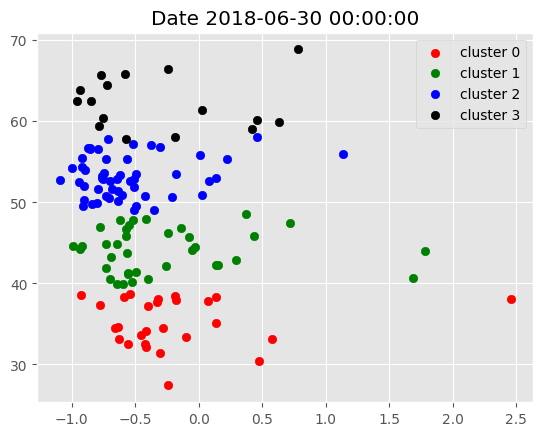

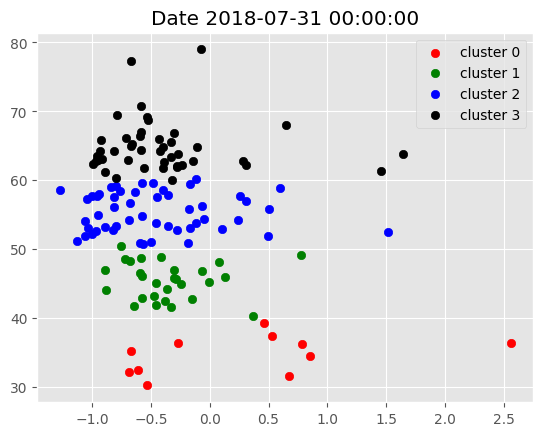

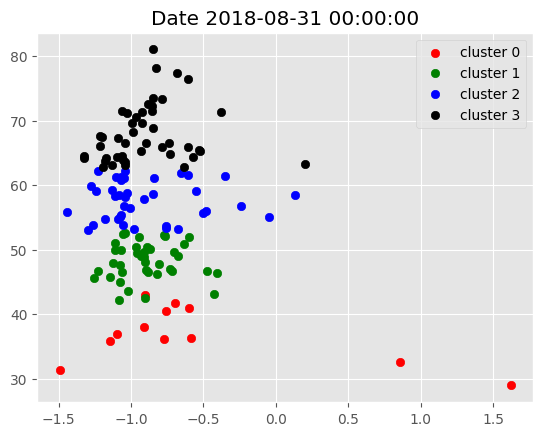

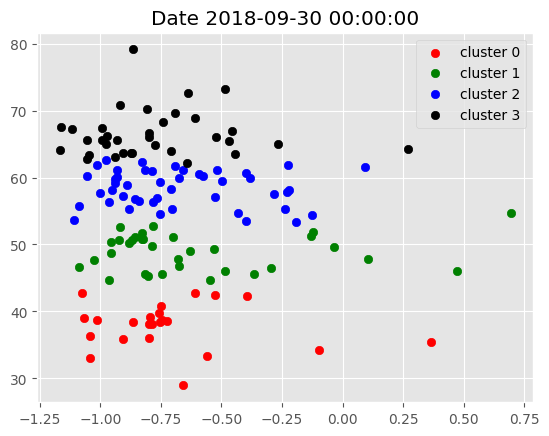

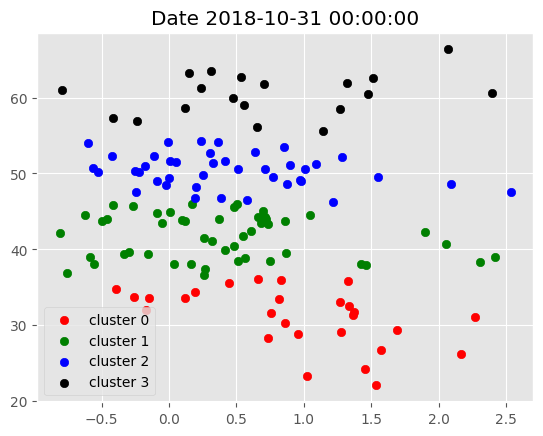

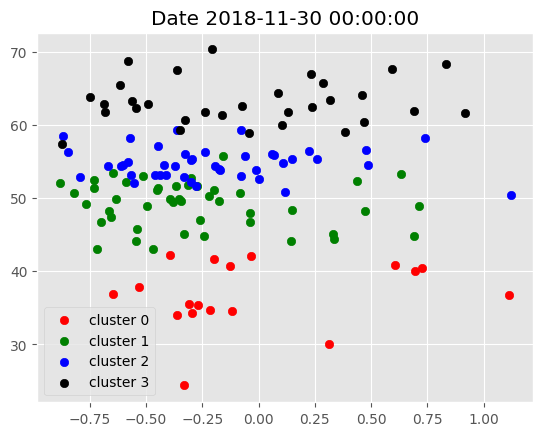

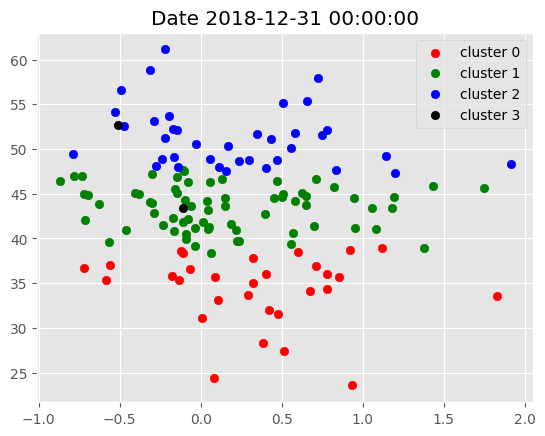

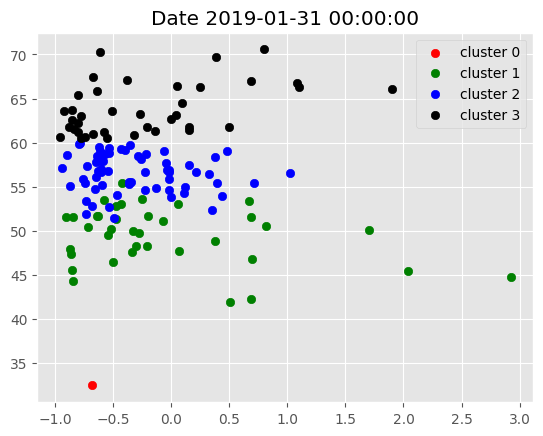

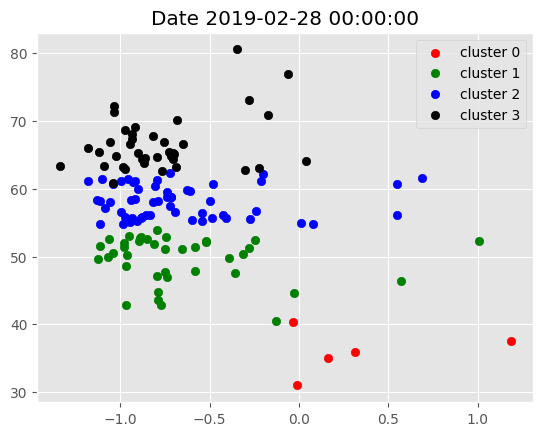

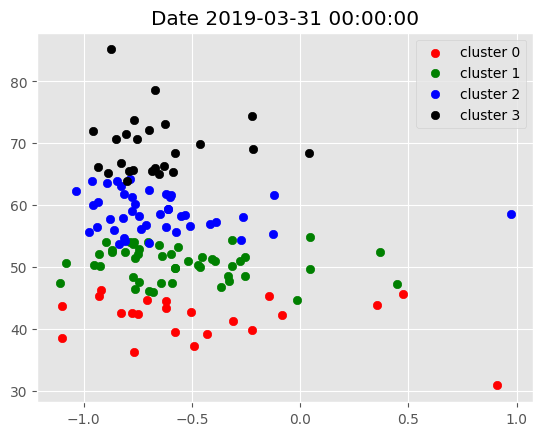

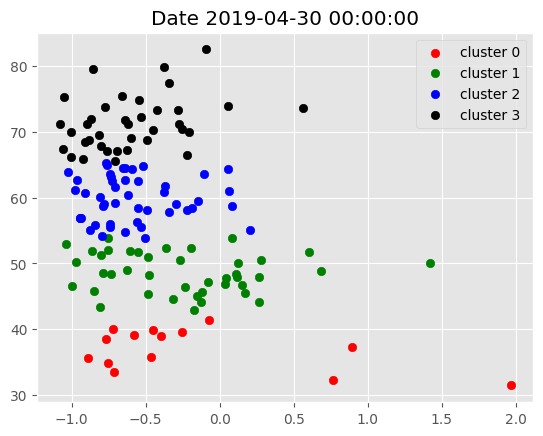

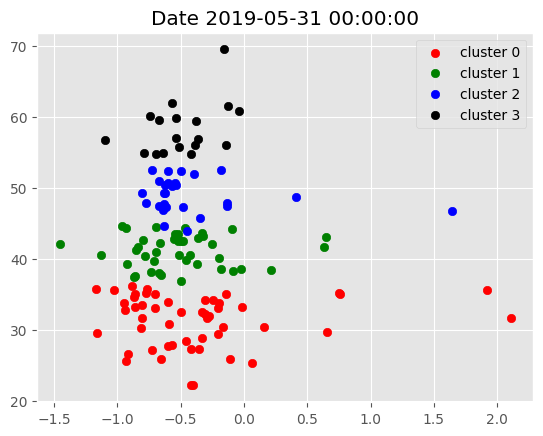

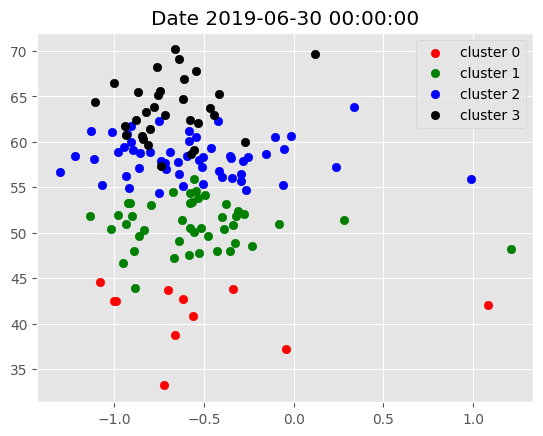

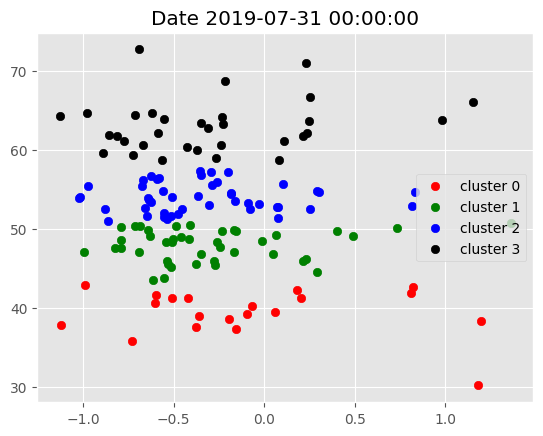

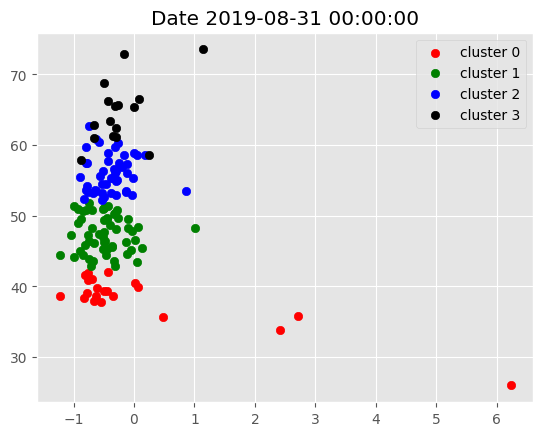

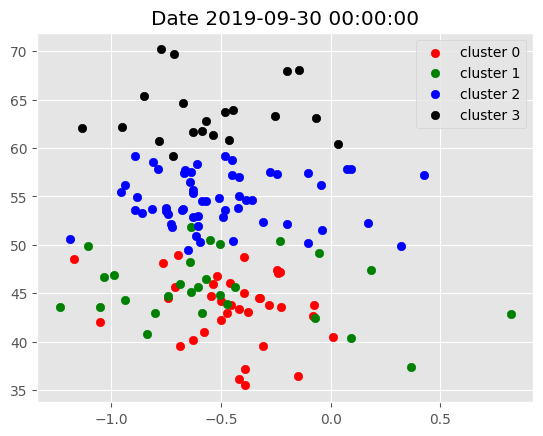

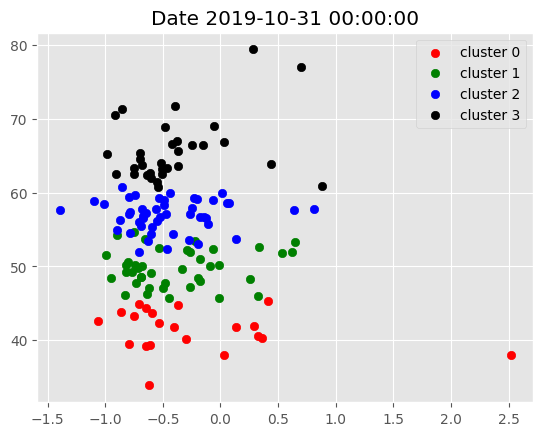

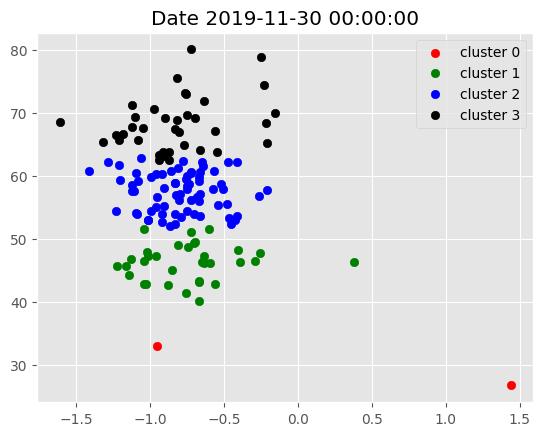

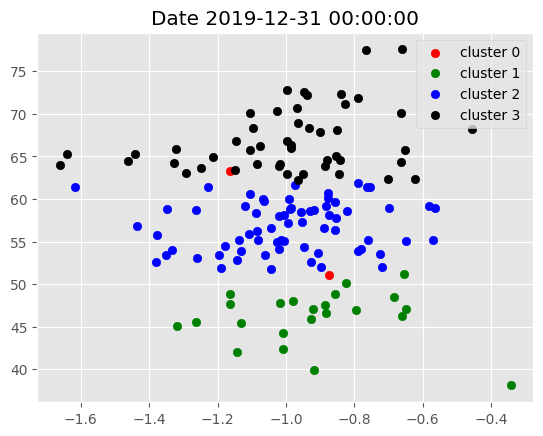

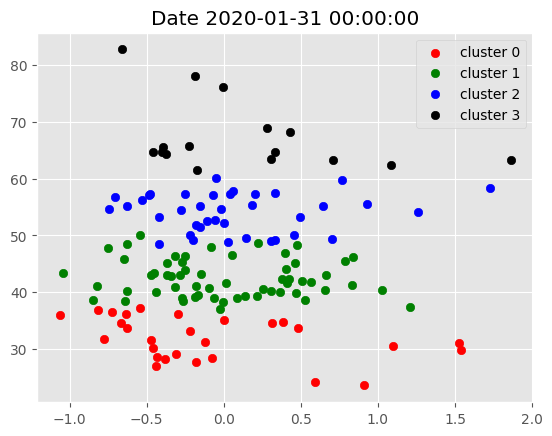

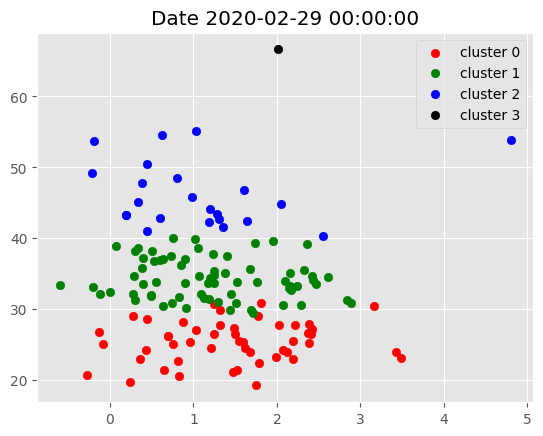

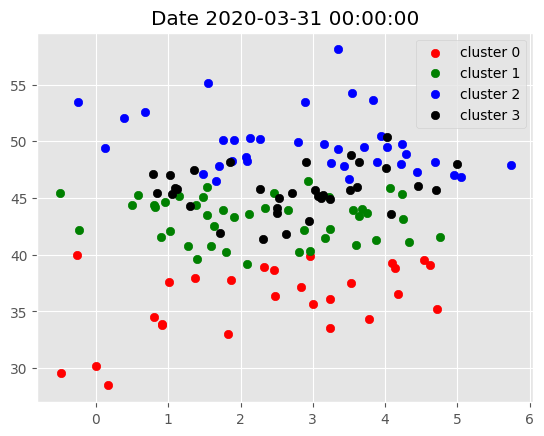

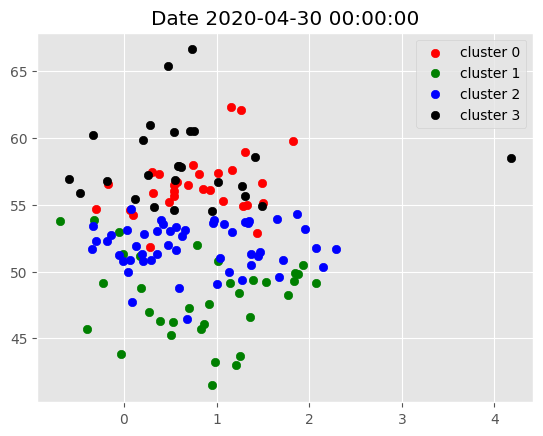

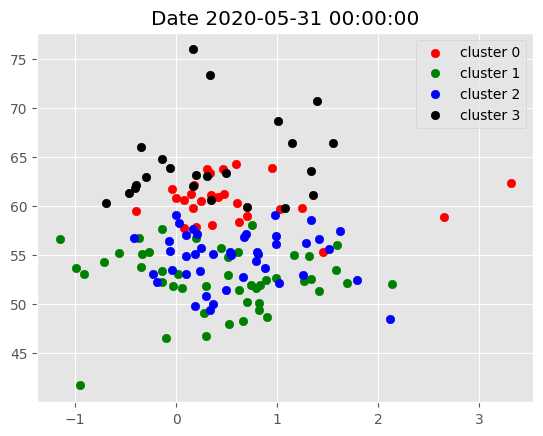

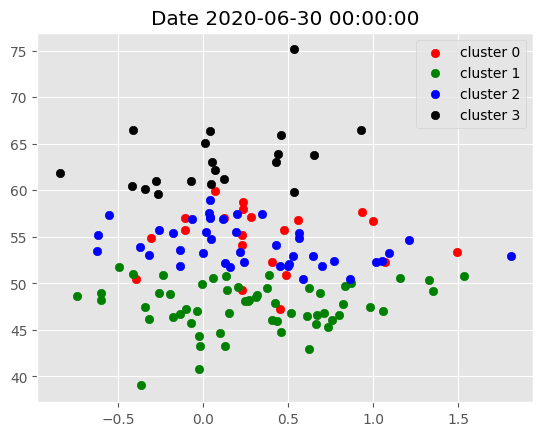

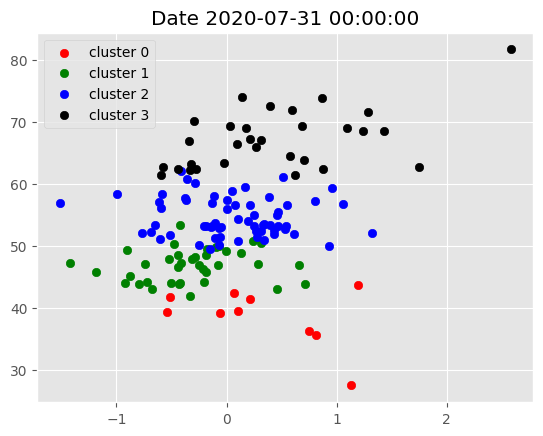

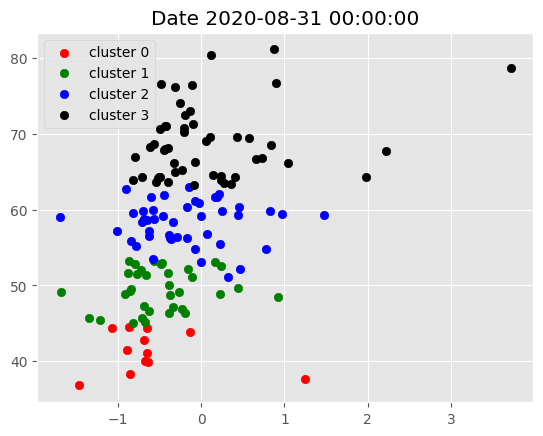

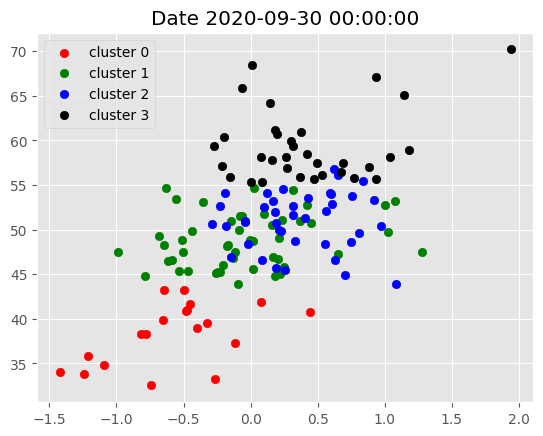

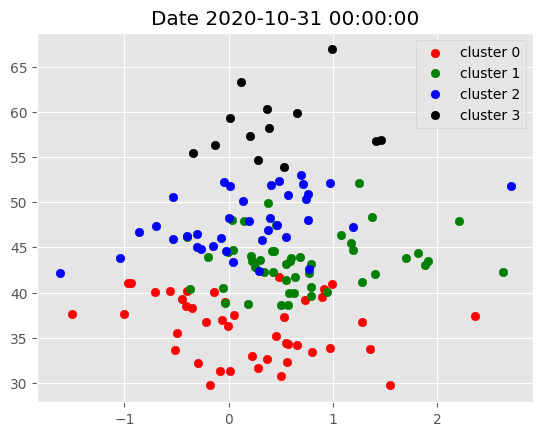

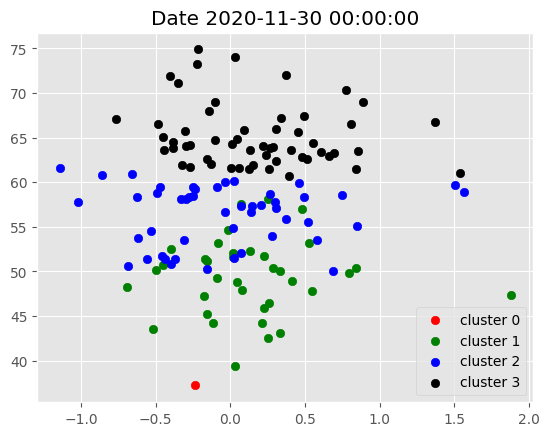

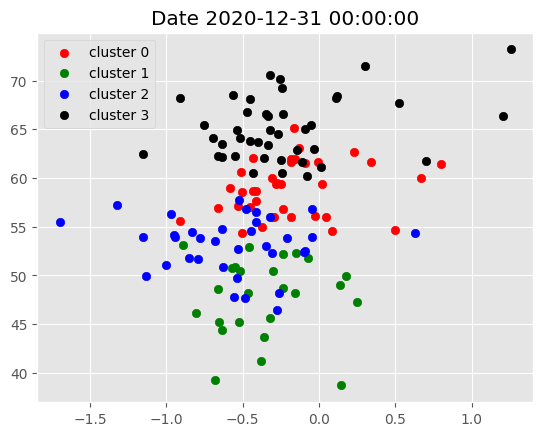

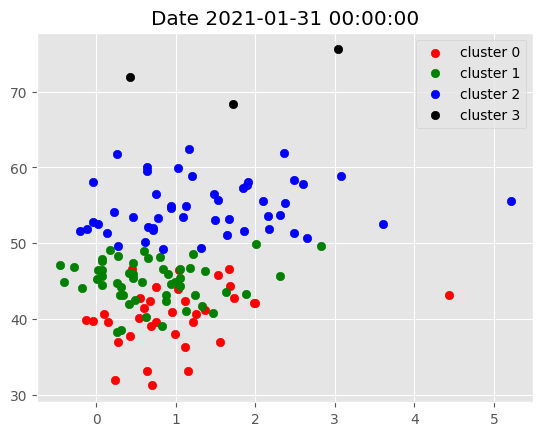

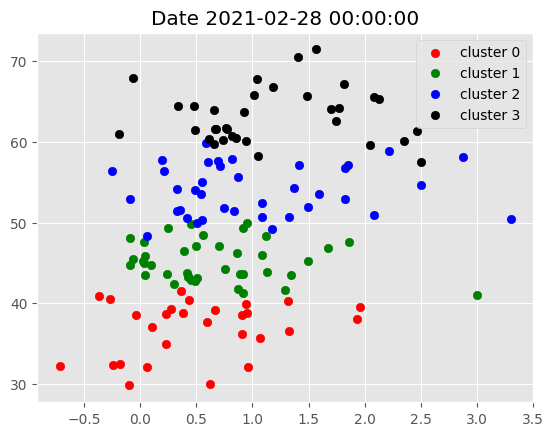

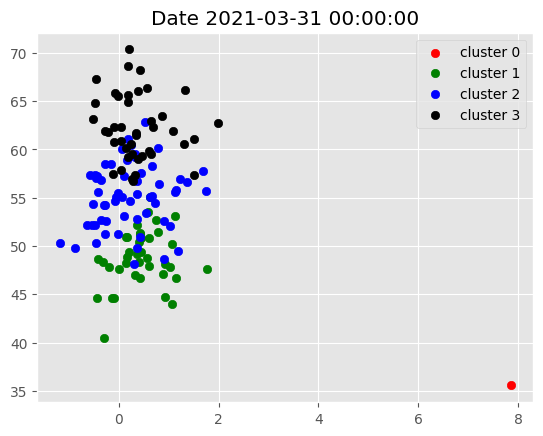

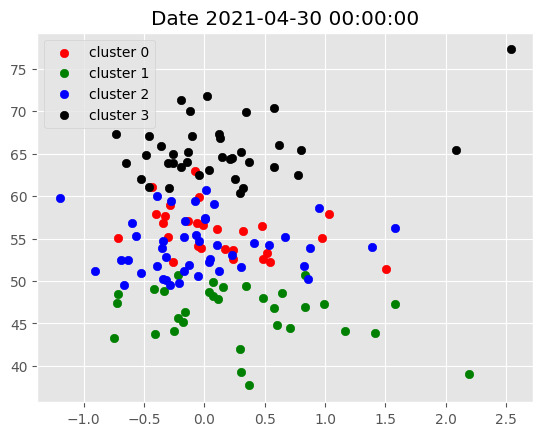

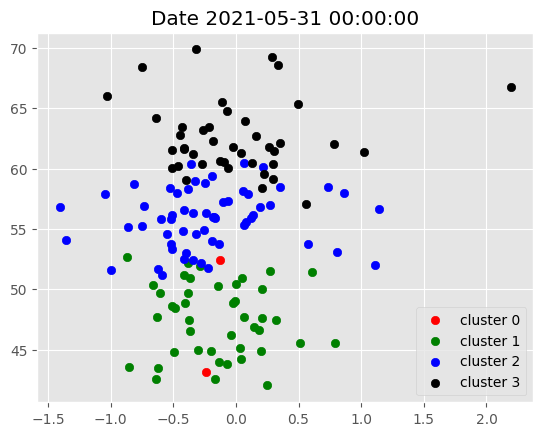

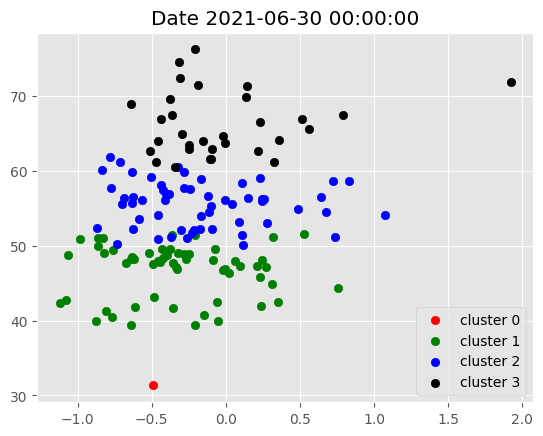

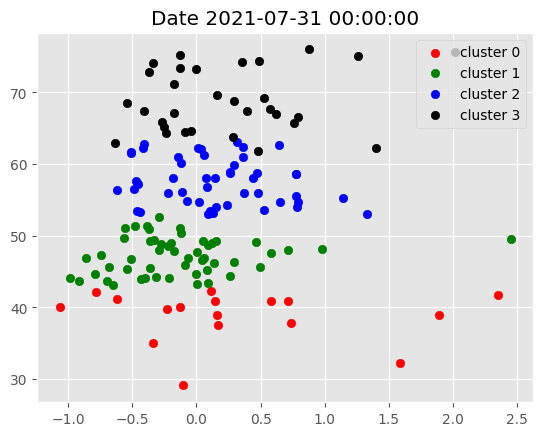

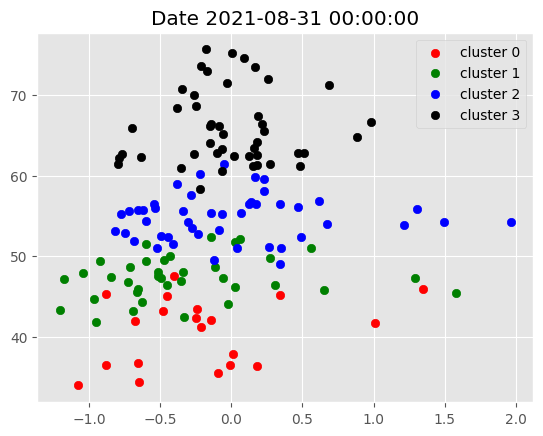

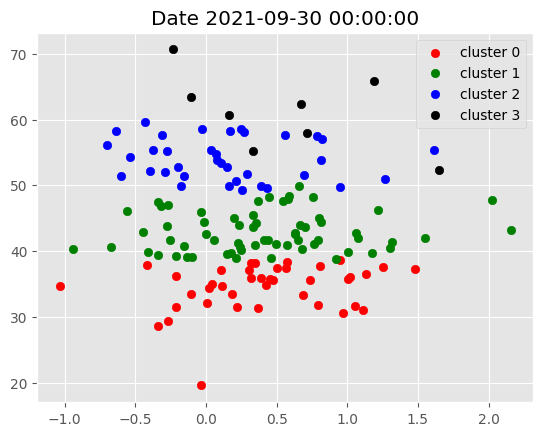

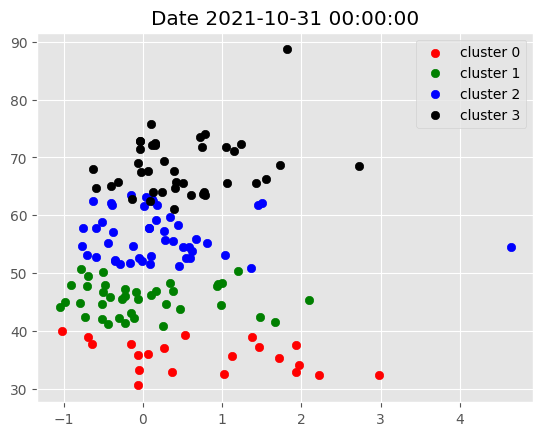

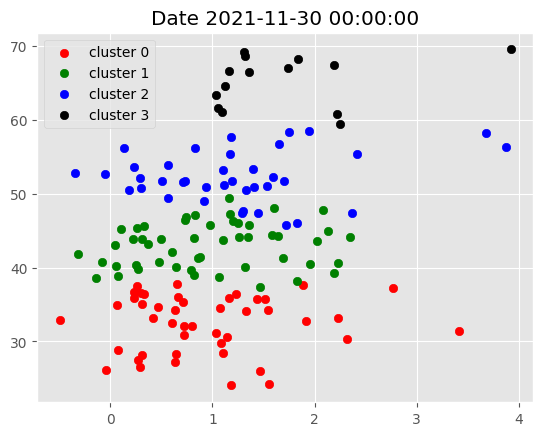

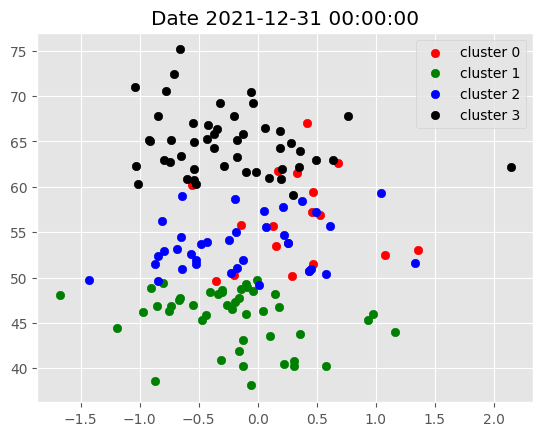

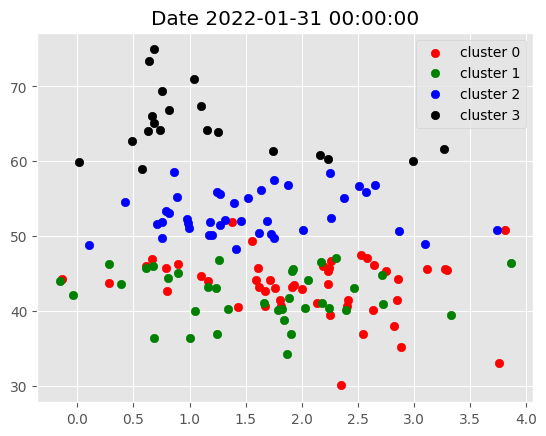

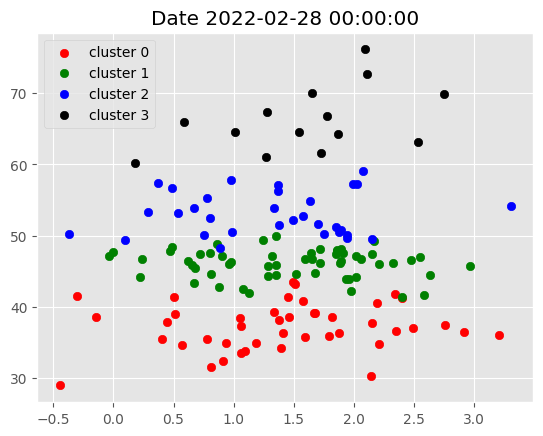

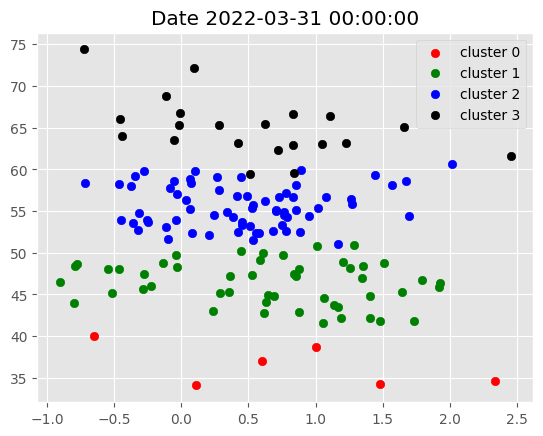

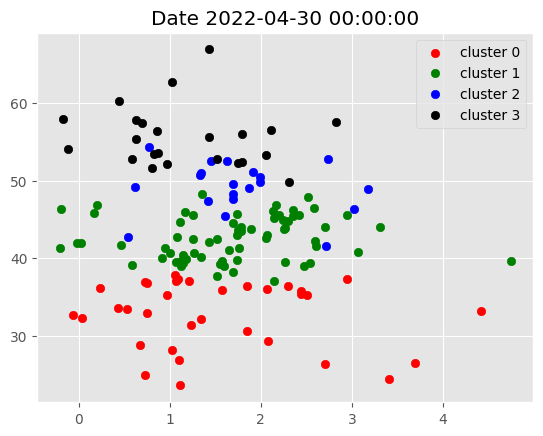

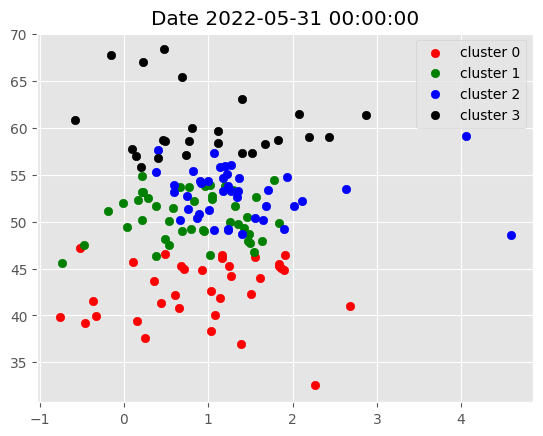

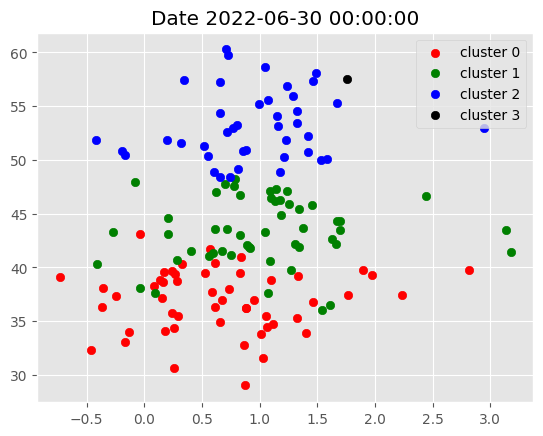

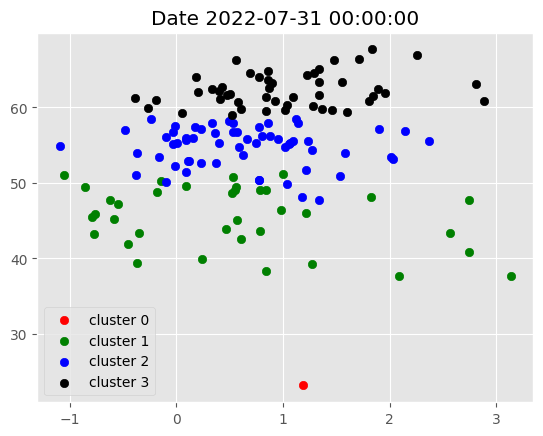

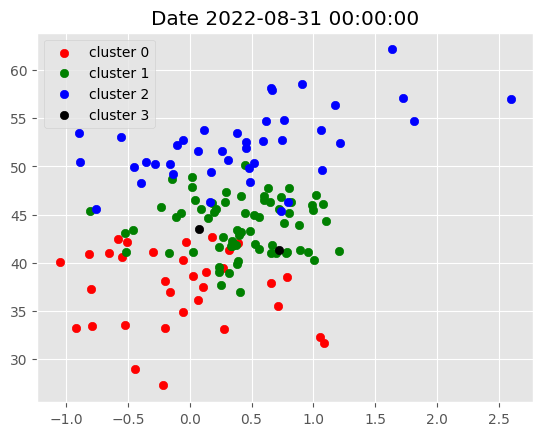

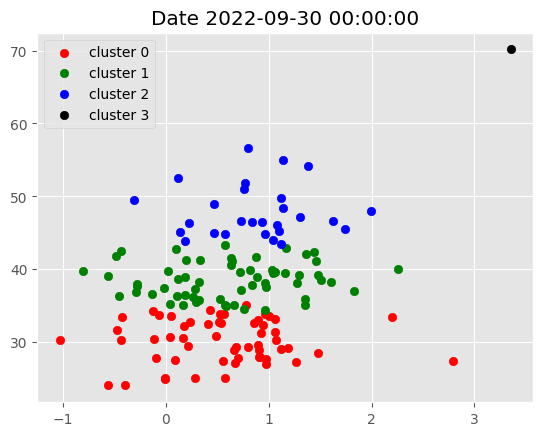

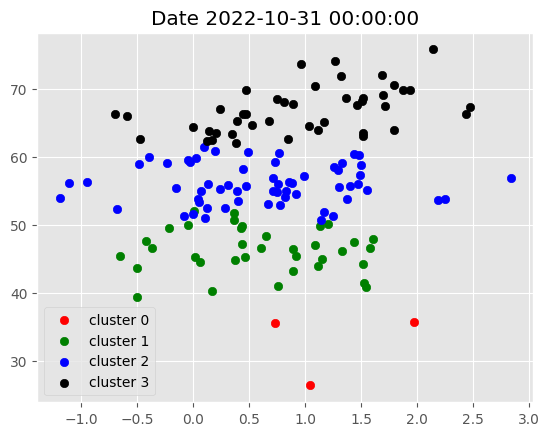

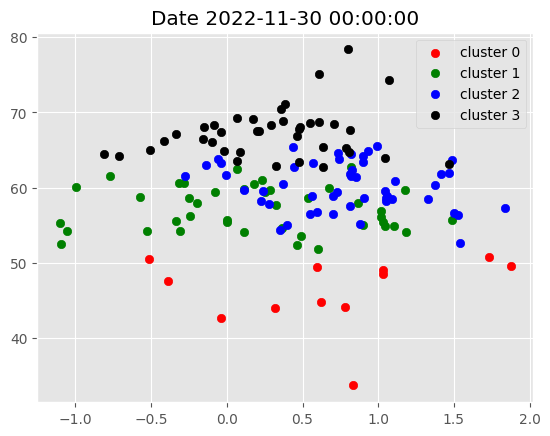

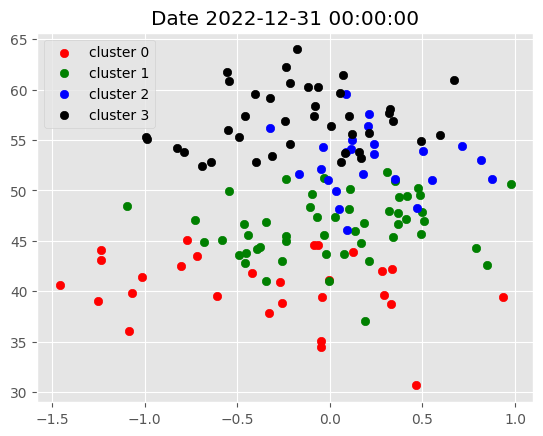

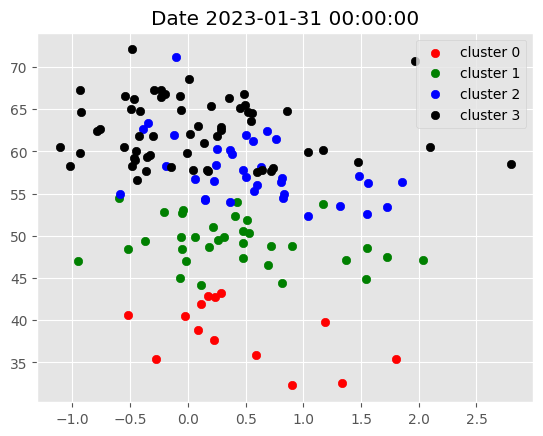

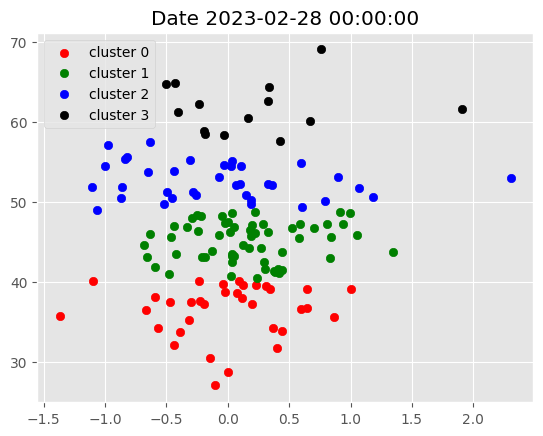

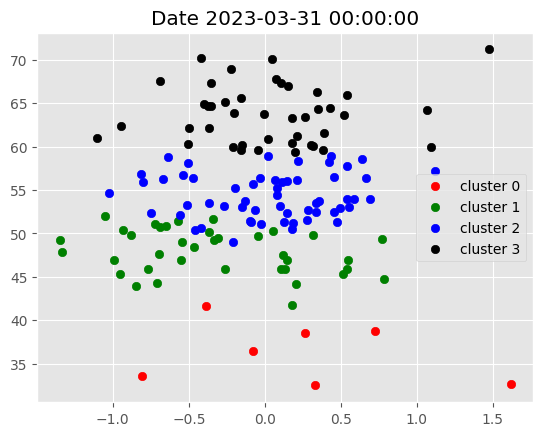

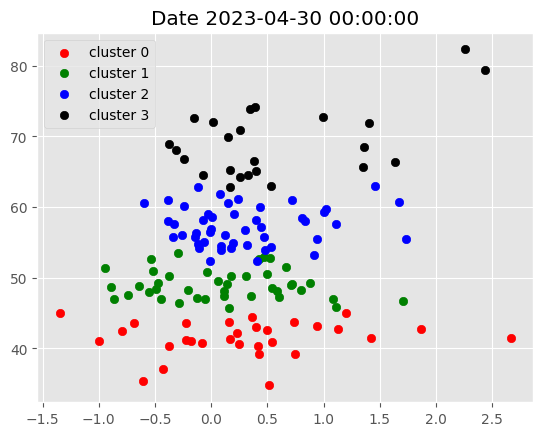

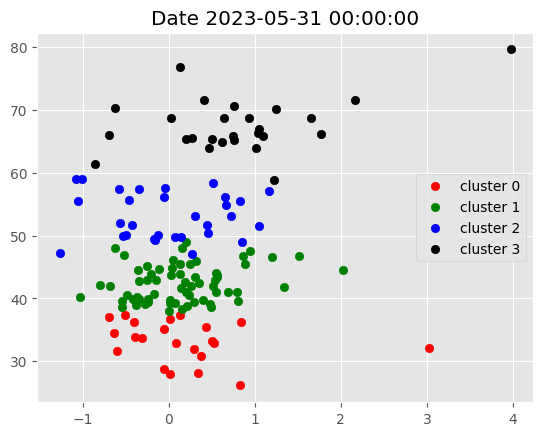

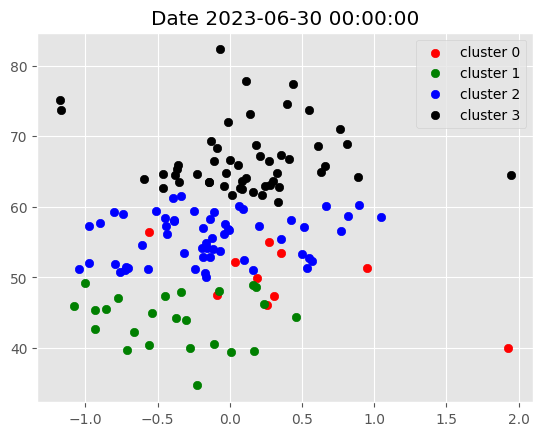

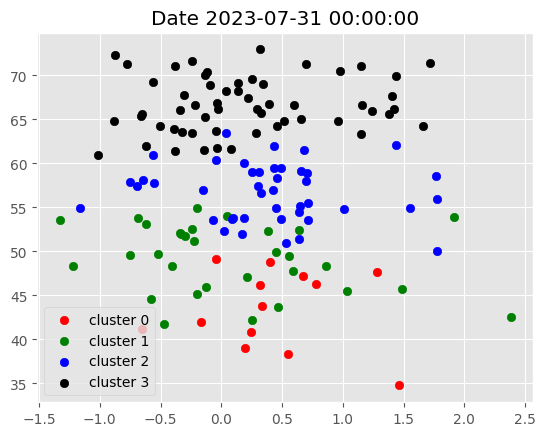

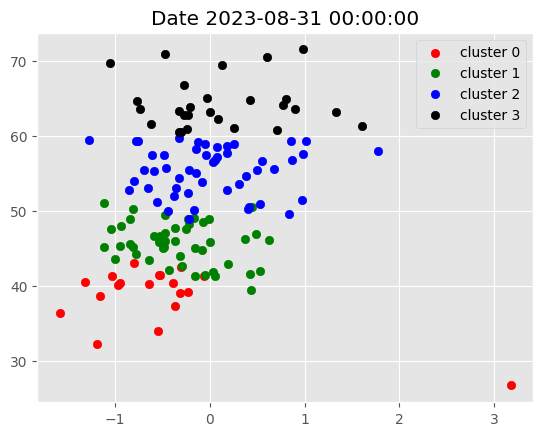

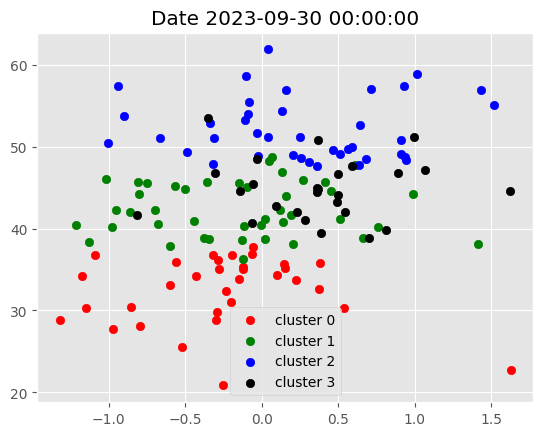

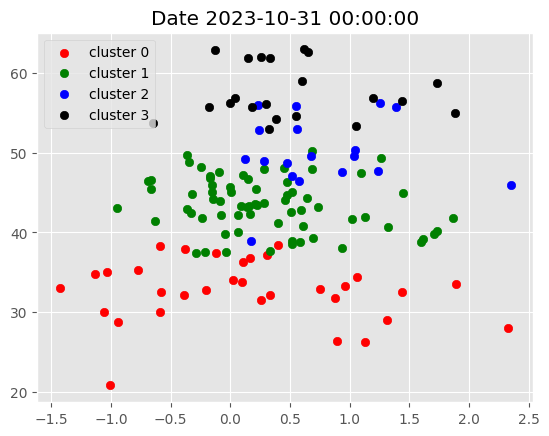

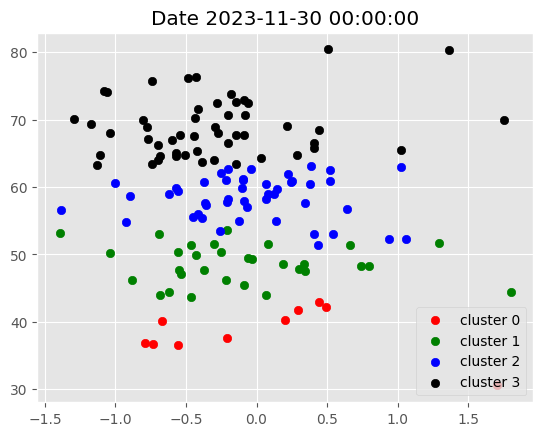

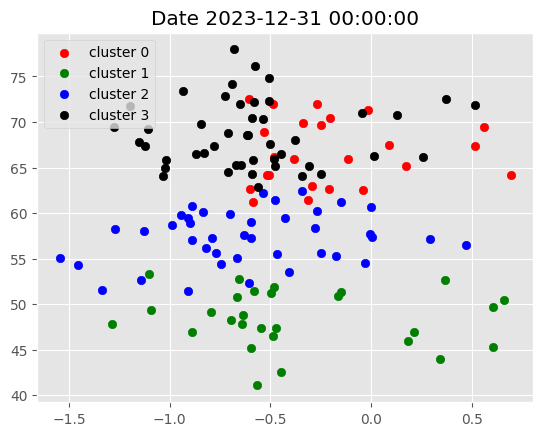

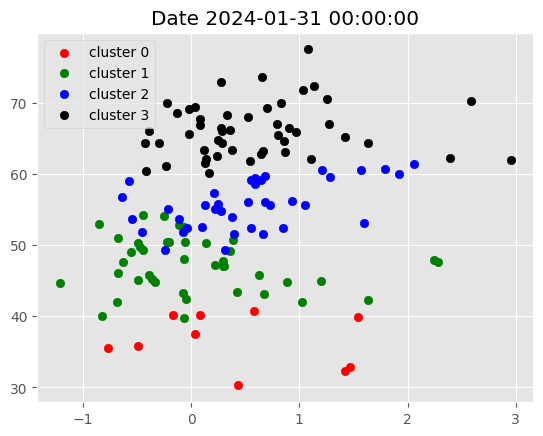

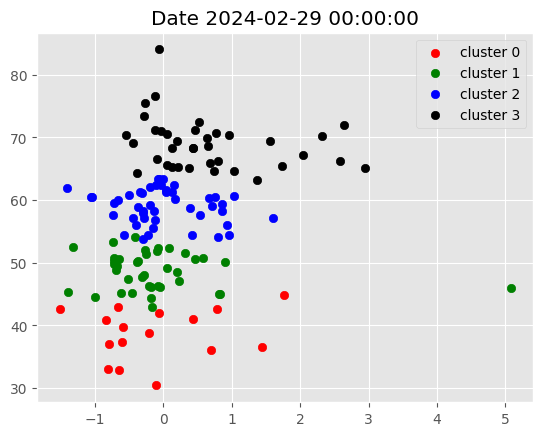

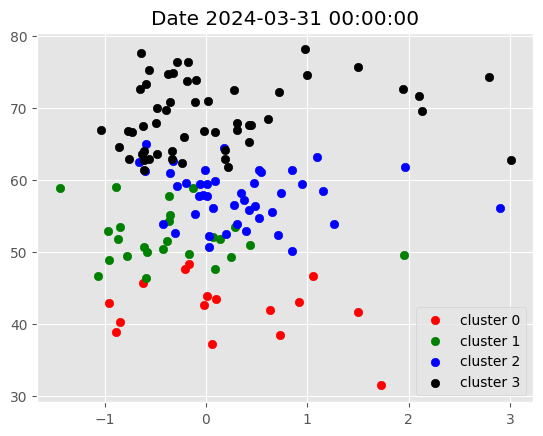

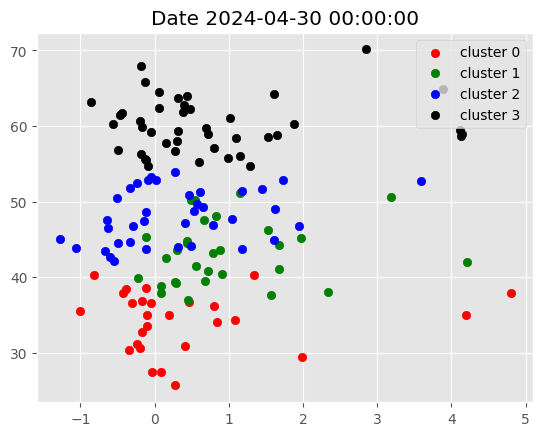

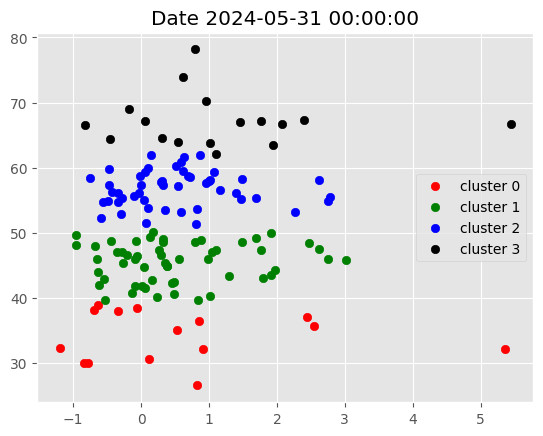

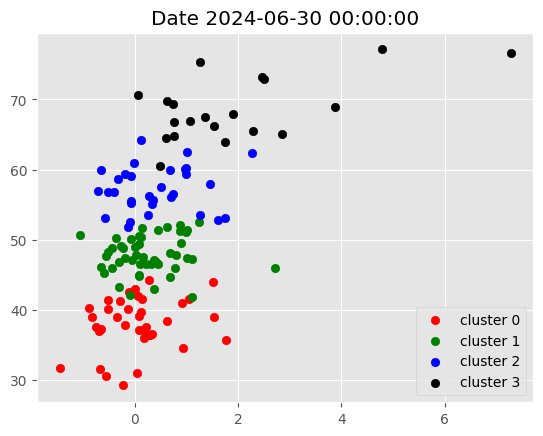

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
- Hypothesis: stocks with RSI = 70 have a persistent momentum, which could continue to outperform in the following month
- solution: find the stocks clustered around RSI 70 centroid (cluster 3 in our case)

In [ ]:
# stocks could be outperform next month
filtered_df = data[data['cluster']==3].copy()
filtered_df

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-06-30 ACN    -0.190635  5.034309  4.970734  5.002521        -10.422568   
           AMT    -0.955100  4.841754  4.770936  4.806345         -9.821791   
           BDX     0.025583  5.380783  5.317986  5.349385        -12.137329   
           COST   -0.938100  5.276907  5.195854  5.236380        -11.581878   
           CRM    -0.575890  4.948954  4.882775  4.915865         -9.600902   
...                     ...       ...       ...       ...               ...   
2024-06-30 QCOM    1.356541  5.395425  5.276706  5.336065        -11.695749   
           REGN    0.744528  6.941138  6.865801  6.903469        -20.506952   
           TJX     0.060247  4.720153  4.586901  4.653527         -8.609398   
           VRTX    0.619451  6.212992  6.068019  6.140505        -15.938021   
           WMT     0.762902  4.229322  4.174375  4.201848         -6.692468   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-06-30 ACN     0.038532  58.053386   0.050405   0.040166   0.024443   
           AMT     0.358542  62.475822   0.047739   0.031108   0.000914   
           BDX     0.896229  61.337505   0.084608   0.018097   0.035114   
           COST    0.085207  63.843712   0.054177   0.031040   0.036111   
           CRM     0.227069  57.849312   0.054666   0.061775   0.054577   
...                     ...        ...        ...        ...        ...   
2024-06-30 QCOM    2.821177  67.452122   0.055281   0.141780   0.084945   
           REGN    1.527940  69.372198   0.057501   0.078780   0.025008   
           TJX     2.728320  70.695880   0.052376   0.075888   0.024042   
           VRTX    3.404873  69.809146   0.055761   0.106265   0.047703   
           WMT     2.402235  66.776552   0.019160   0.064491   0.037787   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-06-30 ACN      0.012599   0.023607    0.025152  1.214180 -0.187579   
           AMT      0.003553   0.007713    0.008913  0.628258 -0.115799   
           BDX      0.020069   0.023591    0.018419  0.738540 -0.389206   
           COST     0.020445   0.028070    0.023543  0.784086 -0.241839   
           CRM      0.049235   0.042951    0.038583  1.112074 -0.371901   
...                      ...        ...         ...       ...       ...   
2024-06-30 QCOM     0.070214   0.078195    0.052609  0.973016  0.232918   
           REGN     0.027993   0.025967    0.031005  0.180610  0.142172   
           TJX      0.025773   0.023646    0.022014  0.760297  0.174525   
           VRTX     0.028184   0.036639    0.026335  0.509512  0.091933   
           WMT      0.042561   0.026960    0.021931  0.610356 -0.383203   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-06-30 ACN    -0.258156  0.323914  0.093550        3  
           AMT    -0.392937  0.388030  0.436147        3  
           BDX    -0.215109 -0.839457  1.245695        3  
           COST   -0.500567  0.318607  0.168752        3  
           CRM    -0.197665  0.234864 -0.884520        3  
...                     ...       ...       ...      ...  
2024-06-30 QCOM   -0.190622  1.534520 -0.331112        3  
           REGN   -0.669404 -0.498896  0.294517        3  
           TJX     0.189702  0.308115 -0.469629        3  
           VRTX   -0.891581  0.067606  0.854369        3  
           WMT    -0.374702  0.237732  0.687173        3  

[2226 rows x 19 columns]

In [ ]:
filtered_df = filtered_df.reset_index(level=1)
filtered_df

,ticker,atr,bb_high,bb_low,bb_mid,garman_klass_vol,macd,rsi,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster
date,,,,,,,,,,,,,,,,,,,,
2018-06-30,ACN,-0.190635,5.034309,4.970734,5.002521,-10.422568,0.038532,58.053386,0.050405,0.040166,0.024443,0.012599,0.023607,0.025152,1.214180,-0.187579,-0.258156,0.323914,0.093550,3
2018-06-30,AMT,-0.955100,4.841754,4.770936,4.806345,-9.821791,0.358542,62.475822,0.047739,0.031108,0.000914,0.003553,0.007713,0.008913,0.628258,-0.115799,-0.392937,0.388030,0.436147,3
2018-06-30,BDX,0.025583,5.380783,5.317986,5.349385,-12.137329,0.896229,61.337505,0.084608,0.018097,0.035114,0.020069,0.023591,0.018419,0.738540,-0.389206,-0.215109,-0.839457,1.245695,3
2018-06-30,COST,-0.938100,5.276907,5.195854,5.236380,-11.581878,0.085207,63.843712,0.054177,0.031040,0.036111,0.020445,0.028070,0.023543,0.784086,-0.241839,-0.500567,0.318607,0.168752,3
2018-06-30,CRM,-0.575890,4.948954,4.882775,4.915865,-9.600902,0.227069,57.849312,0.054666,0.061775,0.054577,0.049235,0.042951,0.038583,1.112074,-0.371901,-0.197665,0.234864,-0.884520,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,QCOM,1.356541,5.395425,5.276706,5.336065,-11.695749,2.821177,67.452122,0.055281,0.141780,0.084945,0.070214,0.078195,0.052609,0.973016,0.232918,-0.190622,1.534520,-0.331112,3
2024-06-30,REGN,0.744528,6.941138,6.865801,6.903469,-20.506952,1.527940,69.372198,0.057501,0.078780,0.025008,0.027993,0.025967,0.031005,0.180610,0.142172,-0.669404,-0.498896,0.294517,3
2024-06-30,TJX,0.060247,4.720153,4.586901,4.653527,-8.609398,2.728320,70.695880,0.052376,0.075888,0.024042,0.025773,0.023646,0.022014,0.760297,0.174525,0.189702,0.308115,-0.469629,3


In [ ]:
# all the index (date) are at the last day of month, we dis
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df

,ticker,atr,bb_high,bb_low,bb_mid,garman_klass_vol,macd,rsi,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster
date,,,,,,,,,,,,,,,,,,,,
2018-07-01,ACN,-0.190635,5.034309,4.970734,5.002521,-10.422568,0.038532,58.053386,0.050405,0.040166,0.024443,0.012599,0.023607,0.025152,1.214180,-0.187579,-0.258156,0.323914,0.093550,3
2018-07-01,AMT,-0.955100,4.841754,4.770936,4.806345,-9.821791,0.358542,62.475822,0.047739,0.031108,0.000914,0.003553,0.007713,0.008913,0.628258,-0.115799,-0.392937,0.388030,0.436147,3
2018-07-01,BDX,0.025583,5.380783,5.317986,5.349385,-12.137329,0.896229,61.337505,0.084608,0.018097,0.035114,0.020069,0.023591,0.018419,0.738540,-0.389206,-0.215109,-0.839457,1.245695,3
2018-07-01,COST,-0.938100,5.276907,5.195854,5.236380,-11.581878,0.085207,63.843712,0.054177,0.031040,0.036111,0.020445,0.028070,0.023543,0.784086,-0.241839,-0.500567,0.318607,0.168752,3
2018-07-01,CRM,-0.575890,4.948954,4.882775,4.915865,-9.600902,0.227069,57.849312,0.054666,0.061775,0.054577,0.049235,0.042951,0.038583,1.112074,-0.371901,-0.197665,0.234864,-0.884520,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,QCOM,1.356541,5.395425,5.276706,5.336065,-11.695749,2.821177,67.452122,0.055281,0.141780,0.084945,0.070214,0.078195,0.052609,0.973016,0.232918,-0.190622,1.534520,-0.331112,3
2024-07-01,REGN,0.744528,6.941138,6.865801,6.903469,-20.506952,1.527940,69.372198,0.057501,0.078780,0.025008,0.027993,0.025967,0.031005,0.180610,0.142172,-0.669404,-0.498896,0.294517,3
2024-07-01,TJX,0.060247,4.720153,4.586901,4.653527,-8.609398,2.728320,70.695880,0.052376,0.075888,0.024042,0.025773,0.023646,0.022014,0.760297,0.174525,0.189702,0.308115,-0.469629,3


In [ ]:
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-07-01': ['ACN',
  'AMT',
  'BDX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'NEE',
  'NFLX',
  'NKE',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'C',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'KR',
  'LLY',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ABT',
  'ACN',
  'ADP',
  'AMD',
  'AMGN',
  'AMZN',
  'AZO',
  'BDX',
  'CMCSA',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'DAL',
  'DG',
  'ELV',
  'HUM',
  'ISRG',
  'LLY',
  'LOW',
  'LUV',
  'MA',
  'MDT',
  'MRK',
  'MSFT',
  'NVDA',
  'ORLY',
  'PANW',
  'PFE',
  'PYPL',
  'QCOM',
  'REGN',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'ULTA',
  'UNH',
  'UPS',
  'V',
  'VRTX',
  '

# Define portfolio optimization function
- We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

- Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [ ]:
!pip install pyportfolioopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

  # Calculate expected returns and sample covariance
  returns = expected_returns.mean_historical_return(prices, frequency=252)
  cov = risk_models.sample_cov(prices, frequency=252)

  # Optimize for maximal Sharpe ratio
  ef = EfficientFrontier(expected_returns = returns,
                         cov_matrix = cov,
                         weight_bounds=(lower_bound, .1),
                         solver='SCS')
  weights = ef.max_sharpe()

  return ef.clean_weights()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.3 MB/s eta 0:00:00


In [ ]:
# download fresh daily prices data only for short listed stocks
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])


[*********************100%%**********************]  156 of 156 completed


In [ ]:
yf

<module 'yfinance' from '/usr/local/lib/python3.10/dist-packages/yfinance/__init__.py'>

Calculate daily returns for each stock which could land up in our portfolio.

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculated each day portfolio return.

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
  cols = fixed_dates[start_date]

  optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
  optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

  print(cols)
  print(start_date)
  print(end_date)
  print(optimization_start_date)
  print(optimization_end_date)

['ACN', 'AMT', 'BDX', 'COST', 'CRM', 'EA', 'EOG', 'KR', 'NEE', 'NFLX', 'NKE', 'PEP', 'PG', 'REGN', 'SHW', 'TJX']
2018-07-01
2018-07-31
2017-07-01
2018-06-30
['ABT', 'AMD', 'AMGN', 'AMT', 'BDX', 'BMY', 'C', 'CMCSA', 'COST', 'CSX', 'DIS', 'ELV', 'EOG', 'EXPE', 'GILD', 'HON', 'JNJ', 'JPM', 'KO', 'KR', 'LLY', 'LUV', 'MDLZ', 'MDT', 'MMM', 'MRK', 'ORLY', 'PEP', 'PFE', 'PG', 'PM', 'QCOM', 'REGN', 'RTX', 'SHW', 'TGT', 'TJX', 'TMO', 'UAL', 'UNP', 'UPS', 'USB', 'VLO', 'WMT']
2018-08-01
2018-08-31
2017-08-01
2018-07-31
['AAPL', 'ABT', 'ACN', 'ADP', 'AMD', 'AMGN', 'AMZN', 'AZO', 'BDX', 'CMCSA', 'COST', 'CRM', 'CSCO', 'CSX', 'CVS', 'DAL', 'DG', 'ELV', 'HUM', 'ISRG', 'LLY', 'LOW', 'LUV', 'MA', 'MDT', 'MRK', 'MSFT', 'NVDA', 'ORLY', 'PANW', 'PFE', 'PYPL', 'QCOM', 'REGN', 'SHW', 'TGT', 'TJX', 'TMO', 'UAL', 'ULTA', 'UNH', 'UPS', 'V', 'VRTX', 'WMT']
2018-09-01
2018-09-30
2017-09-01
2018-08-31
['ABT', 'ADP', 'AMD', 'AMGN', 'AVGO', 'CI', 'COP', 'CSCO', 'CVS', 'DHR', 'DIS', 'EOG', 'HON', 'ISRG', 'LLY', 'LMT

In [ ]:
optimization_df = new_df['2017-07-01':optimization_end_date]['Adj Close'][cols]
optimization_df

Ticker,AAPL,ADBE,AMAT,AVGO,BKNG,COST,CRWD,ISRG,LLY,LRCX,MSFT,MU,NFLX,NVDA,ORCL,QCOM,REGN,TJX,VRTX,WMT
Date,,,,,,,,,,,,,,,,,,,,
2017-07-03,33.581715,138.410004,37.833458,182.607483,1834.203247,142.553696,NaN,102.406670,73.235558,125.527153,62.749542,28.594206,146.169998,3.440710,44.100773,45.215542,487.730011,32.355099,128.229996,22.169254
2017-07-05,33.719776,141.210007,38.857479,184.077805,1856.972534,141.835617,NaN,104.232224,73.235558,128.447037,63.587185,29.938545,147.610001,3.532574,44.190121,45.626957,497.000000,32.178787,129.000000,22.157482
2017-07-06,33.401524,140.750000,38.848251,186.803909,1863.232178,141.000824,NaN,103.866669,72.261429,129.672653,63.117722,29.536228,146.250000,3.543193,43.645111,45.083885,490.190002,31.776438,128.460007,22.201611
2017-07-07,33.740852,142.220001,40.167500,190.443909,1909.208252,138.326096,NaN,104.918892,72.872467,133.493713,63.936943,29.634354,150.179993,3.624191,44.091846,45.544674,496.500000,31.803556,130.350006,22.160429
2017-07-10,33.946785,143.339996,40.785599,192.152756,1912.512207,135.534637,NaN,105.250000,72.863640,135.935913,64.415634,29.928734,152.669998,3.795573,44.333076,45.783314,499.910004,31.048603,128.660004,21.542654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,208.139999,524.169983,229.839996,1592.209961,3981.199951,848.159973,377.929993,429.040009,890.109985,1024.420044,447.670013,138.888519,669.020020,118.110001,139.889999,200.839996,1063.890015,111.050003,474.950012,68.900002
2024-06-25,209.070007,526.880005,234.270004,1580.790039,4014.379883,855.510010,386.760010,442.309998,904.609985,1052.900024,450.950012,140.996674,672.409973,126.089996,139.169998,202.169998,1071.189941,110.669998,473.820007,67.419998
2024-06-26,213.250000,528.659973,232.169998,1592.000000,3982.379883,856.840027,380.369995,442.559998,901.260010,1055.760010,452.160004,142.235596,677.690002,126.400002,138.229996,197.330002,1069.160034,110.540001,474.000000,68.290001


In [ ]:
round(1/(len(optimization_df.columns)*2), 2)

0.03

In [ ]:
# weights=optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2), 2))
# weights

In [ ]:
optimization_df = new_df['2017-11-01':'2018-10-30']['Adj Close'][fixed_dates['2018-11-01']]
optimization_df

Ticker,AMT,CI,CMCSA,DG,F,GM,JNJ,KO,KR,MCD,MO,MRK,PG,PM,SBUX,TSLA,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,
2017-11-01,120.063934,186.075363,30.793482,75.579651,8.912401,38.129848,116.475075,36.977898,18.101915,141.946564,39.365589,43.061207,73.018059,71.637268,47.859573,21.405333,33.767372,50.592575,26.032738
2017-11-02,121.453751,186.592667,29.999758,76.770630,8.962916,37.661293,116.433487,37.042488,18.344429,143.422623,38.878845,43.084538,72.698723,70.981323,47.633862,19.950666,33.506161,50.418926,26.287319
2017-11-03,121.163879,189.893967,30.452084,76.175133,8.919617,37.431431,116.558319,37.115158,18.621588,143.891891,38.884933,43.621449,72.757561,70.884651,48.640884,20.406000,33.477924,50.486877,26.547827
2017-11-06,128.036346,192.809616,30.332609,75.067909,8.897965,37.254620,116.292061,36.711468,18.474346,145.103394,38.605057,43.481384,72.312157,70.525620,49.109661,20.185333,32.143597,49.784729,26.257721
2017-11-07,128.462677,193.270447,31.058062,75.049309,8.775290,36.865635,116.300362,37.090927,18.457018,145.700653,39.128307,43.255730,73.093681,71.133217,49.673943,20.403334,32.171844,51.279617,26.331722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-24,132.370331,189.956909,29.732971,104.454918,6.327467,28.082897,117.460609,39.044952,24.694935,155.115112,39.639328,56.655075,77.827370,64.669975,51.567944,19.233334,42.462086,57.386753,29.560522
2018-10-25,133.711670,197.906296,31.231819,104.511398,6.954026,29.406181,118.315094,38.861130,24.739111,153.330872,40.180073,56.189228,77.427185,65.706734,52.367302,20.990667,41.729988,58.577816,30.051384
2018-10-26,130.314682,194.444321,30.708967,101.490112,6.946290,30.003490,117.033409,38.368160,24.368027,151.607864,40.135532,56.542633,76.435440,64.524986,51.576820,22.059999,41.049637,58.956772,29.978662


In [ ]:
# round(1/(len(optimization_df.columns)*2), 2)

In [ ]:
weights=optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2), 2))
weights

OrderedDict([('AMT', 0.1),
             ('CI', 0.03),
             ('CMCSA', 0.03),
             ('DG', 0.1),
             ('F', 0.03),
             ('GM', 0.03),
             ('JNJ', 0.03),
             ('KO', 0.03),
             ('KR', 0.1),
             ('MCD', 0.03),
             ('MO', 0.03),
             ('MRK', 0.1),
             ('PG', 0.03),
             ('PM', 0.03),
             ('SBUX', 0.03),
             ('TSLA', 0.03),
             ('VZ', 0.1),
             ('WBA', 0.06434),
             ('WMT', 0.07567)])

In [ ]:
weights = pd.DataFrame(weights, index=pd.Series(0))
weights

,AMT,CI,CMCSA,DG,F,GM,JNJ,KO,KR,MCD,MO,MRK,PG,PM,SBUX,TSLA,VZ,WBA,WMT
0,0.1,0.03,0.03,0.1,0.03,0.03,0.03,0.03,0.1,0.03,0.03,0.1,0.03,0.03,0.03,0.03,0.1,0.06434,0.07567


In [ ]:
# prepare weights
weights.stack().to_frame('weight').reset_index(level=0, drop=True)

,weight
AMT,0.10000
CI,0.03000
CMCSA,0.03000
DG,0.10000
F,0.03000
GM,0.03000
JNJ,0.03000
KO,0.03000
KR,0.10000
MCD,0.03000


In [ ]:
# temp_df = returns_dataframe['2017-11-01':'2017-11-30']
# temp_df = temp_df.stack().to_frame('return').reset_index(level=0)
# temp_df

In [ ]:
# temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
#     .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
#            left_index=True,
#            right_index=True)\
#     .reset_index().set_index(['Date', 'index']).unstack().stack()
# temp_df

In [ ]:
from logging import exception
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  try:
      end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
      cols = fixed_dates[start_date]

      optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
      optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
      optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

      success = False # initialize success to False
      try:
          weights = optimize_weights(prices=optimization_df,
                                  lower_bound=round(1/(len(optimization_df.columns)*2),3))

          weights = pd.DataFrame(weights, index=pd.Series(0))

          success = True
      except:
          print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
          print(e) # Print the exception to help diagnose the optimization failure

      # in case the optimization fails
      if success==False:
        weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
              index=optimization_df.columns.tolist(),
              columns=pd.Series(0)).T

      temp_df = returns_dataframe[start_date:end_date]
      temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
        .merge(weights.stack().to_frame('weight').reset_index(level=0), left_index=True, right_index=True)\
        .reset_index().set_index(['Date', 'index']).unstack().stack()

      temp_df.index.name = ['date', 'ticker']
      temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

      temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('strategy return')

      portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

  except Exception as e:
      print(e)

"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
name 'e' is not defined
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
name 'e' is not defined
"None of ['index'] are in the columns"
"None of ['index']

In [ ]:
# portfolio_df.plot()

In [ ]:
portfolio_df = portfolio_df.drop_duplicates()
portfolio_df

# trouble shooting
# https://github.com/robertmartin8/PyPortfolioOpt/issues/88

""


 8. Visualize Portfolio returns and compare to SP500 returns.


In [ ]:
 spy = yf.download(tickers='SPY',
                     start='2015-01-01',
                     end=dt.date.today())

[*********************100%%**********************]  1 of 1 completed


In [ ]:
spy

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,206.380005,206.880005,204.179993,205.429993,173.704941,121465900
2015-01-05,204.169998,204.369995,201.350006,201.720001,170.567886,169632600
2015-01-06,202.089996,202.720001,198.860001,199.820007,168.961319,209151400
2015-01-07,201.419998,202.720001,200.880005,202.309998,171.066803,125346700
2015-01-08,204.009995,206.160004,203.990005,205.899994,174.102341,147217800
...,...,...,...,...,...,...
2024-07-03,548.690002,551.830017,548.650024,551.460022,551.460022,32789900
2024-07-05,551.770020,555.049988,551.119995,554.640015,554.640015,41488400
2024-07-08,555.440002,556.250000,554.190002,555.280029,555.280029,36110500


In [ ]:
 spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)
 portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)
 portfolio_df

,SPY Buy&Hold_x,SPY Buy&Hold_y


In [ ]:
portfolio_df

,SPY Buy&Hold_x,SPY Buy&Hold_y


In [ ]:
spy_ret

,SPY Buy&Hold
Date,
2015-01-05,-0.018225
2015-01-06,-0.009464
2015-01-07,0.012384
2015-01-08,0.017589
2015-01-09,-0.008046
...,...
2024-07-03,0.004453
2024-07-05,0.005750
2024-07-08,0.001153


In [ ]:
plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

TypeError: cannot do slice indexing on RangeIndex with these indexers [2023-09-29] of type str